First, create a new conda environment named BI2025 and install the required packages from requirements.txt


In [1]:
#!conda create -n BI2025 python=3.11 -y
#!conda activate BI2025
#!pip install -r requirements.txt

In [2]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine

## Graph-based documentation preliminaries

**!!!IMPORTANT!!!**

Everytime you work on this notebook, enter your student ID in the `executed_by` variable so that the cell executions are accredited to you.

In [3]:
executed_by ='stud-id_12536887'  # Replace the digits after "id_" with your own student ID

Set your group and student IDs. Do this only once.

In [4]:
# group id for this project
group_id = '79'  # Replace the digits with your group id

# Students working on this notebook
student_a = 'stud-id_12437437'  # Replace the digits after "id_" with student A's student ID
student_b = 'stud-id_12536887'  # Replace the digits after "id_" with student B's student ID

In [5]:
# Roles. Don't change these values.
code_writer_role = 'code_writer'
code_executor_role = 'code_executor'

Setup the starvers API for logging your steps into our server-sided graph database.

In [6]:
get_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025"
post_endpoint = "https://starvers.ec.tuwien.ac.at/BI2025/statements"
engine = TripleStoreEngine(get_endpoint, post_endpoint, skip_connection_test=True)

Use these prefixes in your notebooks. You can extend this dict with your prefixes of additional ontologies that you use in this notebook. Replace 00 with your group id

In [7]:
prefixes = {
    'xsd': 'http://www.w3.org/2001/XMLSchema#',
    'rdfs': 'http://www.w3.org/2000/01/rdf-schema#',
    'foaf': 'http://xmlns.com/foaf/0.1/',
    'prov': 'http://www.w3.org/ns/prov#',
    'sc': 'https://schema.org/',
    'cr': 'http://mlcommons.org/croissant/',
    'mls': 'http://www.w3.org/ns/mls#',
    'mlso': 'http://w3id.org/mlso',
    'siu': 'https://si-digital-framework.org/SI/units/',
    'siq': 'https://si-digital-framework.org/SI/quantities/',
    'qudt': 'http://qudt.org/schema/qudt/',
    '': f'https://starvers.ec.tuwien.ac.at/BI2025/{group_id}/',
}

prefix_header = '\n'.join([f'PREFIX {k}: <{v}>' for k, v in prefixes.items()]) + '\n\n'

Ontologies to use
* Provenance of the experiment process
    * PROV-O: 
        * doc: https://www.w3.org/TR/prov-o/
        * serialization: https://www.w3.org/ns/prov-o
* Data used and created
    * schema.org - Dataset: 
        * doc: https://schema.org/Dataset
        * serialization: https://schema.org/version/latest/schemaorg-current-https.ttl
    * Crossaint
        * doc: https://docs.mlcommons.org/croissant/docs/croissant-spec.html
        * serialization: https://github.com/mlcommons/croissant/blob/main/docs/croissant.ttl
* ML experiments performed
    * MLSO: 
        * doc: https://github.com/dtai-kg/MLSO
        * doc: https://dtai-kg.github.io/MLSO/#http://w3id.org/
        * serialization: https://dtai-kg.github.io/MLSO/ontology.ttl
* Measurements, Metrics, Units
    * QUDT
        * doc:https://qudt.org/
        * doc: https://github.com/qudt/qudt-public-repo
        * serialization: https://github.com/qudt/qudt-public-repo/blob/main/src/main/rdf/schema/SCHEMA_QUDT.ttl
    * SI Digital Framework
        * doc: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/docs/README.md
        * doc: https://si-digital-framework.org/
        * doc: https://si-digital-framework.org/SI
        * serialization: https://github.com/TheBIPM/SI_Digital_Framework/blob/main/SI_Reference_Point/TTL/si.ttl
    * Quantities and Units
        * doc: https://www.omg.org/spec/Commons
        * serialization: https://www.omg.org/spec/Commons/QuantitiesAndUnits.ttl

Use this function to record execution times.

In [8]:
def now() -> str:
    """
    Returns the current time in ISO 8601 format with UTC timezone in the following format:
    YYYY-MM-DDTHH:MM:SS.sssZ
    """
    timestamp = datetime.datetime.now(datetime.timezone.utc)
    timestamp_formated = timestamp.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]  +"Z"

    return timestamp_formated

Register yourself in the Knowledge Graph using ProvO. Change the given name, family name and immatriculation number to reflect your own data.

In [9]:
# import uuid
# print(uuid.uuid4())

In [10]:
student_b_uuid = "7eaadc18-0d73-4080-bfcc-cfbca7a3c0bc"

In [11]:
# Ontologies used: foaf, prov, IAO
reigstration_triples_a = [
f':{student_a} rdf:type foaf:Person .',
f':{student_a} rdf:type prov:Agent .',
f':{student_a} foaf:givenName "Mehmet Fatih" .',
f':{student_a} foaf:familyName "Dogan" .',
f':{student_a} <http://vivoweb.org/ontology/core#identifier> :{student_a} .',
f':{student_a} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_a} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_a} <http://purl.obolibrary.org/obo/IAO_0000219> "12437437"^^xsd:string .',
]

reigstration_triples_b = [
f':{student_b} rdf:type foaf:Person .',
f':{student_b} rdf:type prov:Agent .',
f':{student_b} foaf:givenName "Merve" .',
f':{student_b} foaf:familyName "Yilmaz" .',
f':{student_b} <http://vivoweb.org/ontology/core#identifier> :{student_b} .',
f':{student_b} rdf:type <http://purl.obolibrary.org/obo/IAO_0000578> .',
f':{student_b} <http://www.w3.org/2000/01/rdf-schema#label> "Immatriculation number" .',
f':{student_b} <http://purl.obolibrary.org/obo/IAO_0000219> "12536887"^^xsd:string .',
]

role_triples = [
    f':{code_writer_role} rdf:type prov:Role .',
    f':{code_executor_role} rdf:type prov:Role .',
]


engine.insert(reigstration_triples_a, prefixes=prefixes)
engine.insert(reigstration_triples_b, prefixes=prefixes)
engine.insert(role_triples, prefixes=prefixes)

**What not do do**

Do not use [blank nodes](https://www.w3.org/wiki/BlankNodes).

PROV-O uses blank nodes to connect multiple elements with each other.
Such blank nodes (such as _:association) should not be used.
Instead, assign a fixed node ID such as
:5119fcd7-b571-41e0-9464-a37c7be0f574 by generating them outside of the
notebook.
We suggest that, for each setting where such a blank node is needed to
connect multiple elements, you create a unique hash (using uuid.uuid4())
and keep this as hard-coded identifier for the blank node. The template
notebook contains examples of this. Do *not* use these provided values,
as otherwise, your provenance documentations will all be connected via
these identifiers!
Also, do not generate them dynamically in every cell execution, e.g. by
using uuid.uuid4() in a cell. This would generate many new linking nodes
for connecting the same elements.
Compute one for each node (cell) where you need them and make sure to
use the same one on each re-execution of the notebook.

In [12]:
weather_data_path = os.path.join("data", "datasets", "weather")
cyclists_data_path = os.path.join("data", "datasets", "cyclists")

## B
usiness Understanding 

In [13]:
## Each Activity that follows is part of the Business Understanding Phase

business_understanding_phase_executor = [
f':business_understanding_phase rdf:type prov:Activity .',
f':business_understanding_phase rdfs:label "Business Understanding Phase" .', ## Phase 1: Business Understanding
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [14]:
#############################################
# Documentation
#############################################

data_src_and_scenario_comment = """
...Data source and Scenario description...
Our data source is: https://www.kaggle.com/datasets/systemdesigner/samplecustomerscore and our Scenario provide best model for credit risk calculation
"""

business_objectives_comment = """
Minimize financial losses by accurately predicting loan default probability and identifying high-risk applicants before approval.
"""

business_success_criteria_comment = """
Improving credit decision speed and accuracy through automation.
"""

data_mining_goals_comment = """
Develop a classification model to accurately predict the probability of loan default.
"""

data_mining_success_criteria_comment = """
Achieving an AUC-ROC score of 0.80 or higher and a Gini coefficient above 0.60.
"""

ai_risk_aspects_comment = """
Lack of model explainability (black-box risk) and the need for transparent reasoning behind loan rejections.
"""


bu_ass_uuid_executor = "a31e5ce9-f9fe-48f9-94cc-fee4d0c332c4" # Generate once
business_understanding_executor = [
f':business_understanding rdf:type prov:Activity .',
f':business_understanding sc:isPartOf :business_understanding_phase .', # Connect Activity to Parent Business Understanding Phase Activity
f':business_understanding prov:qualifiedAssociation :{bu_ass_uuid_executor} .',
f':{bu_ass_uuid_executor} prov:agent :{executed_by} .',
f':{bu_ass_uuid_executor} rdf:type prov:Association .',
f':{bu_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(business_understanding_executor, prefixes=prefixes)


business_understanding_data_executor = [
# 1a
f':bu_data_source_and_scenario rdf:type prov:Entity .',
f':bu_data_source_and_scenario prov:wasGeneratedBy :business_understanding .',
f':bu_data_source_and_scenario rdfs:label "1a Data Source and Scenario" .',
f':bu_data_source_and_scenario rdfs:comment """{data_src_and_scenario_comment}""" .',
# 1b
f':bu_business_objectives rdf:type prov:Entity .',
f':bu_business_objectives prov:wasGeneratedBy :business_understanding .',
f':bu_business_objectives rdfs:label "1b Business Objectives" .',
f':bu_business_objectives rdfs:comment """{business_objectives_comment}""" .',
# 1c
f':bu_business_success_criteria rdf:type prov:Entity .',
f':bu_business_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_business_success_criteria rdfs:label "1c Business Success Criteria" .',
f':bu_business_success_criteria rdfs:comment """{business_success_criteria_comment}""" .',
# 1d
f':bu_data_mining_goals rdf:type prov:Entity .',
f':bu_data_mining_goals prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_goals rdfs:label "1d Data Mining Goals" .',
f':bu_data_mining_goals rdfs:comment """{data_mining_goals_comment}""" .',
# 1e
f':bu_data_mining_success_criteria rdf:type prov:Entity .',
f':bu_data_mining_success_criteria prov:wasGeneratedBy :business_understanding .',
f':bu_data_mining_success_criteria rdfs:label "1e Data Mining Success Criteria" .',
f':bu_data_mining_success_criteria rdfs:comment """{data_mining_success_criteria_comment}""" .',
# 1f
f':bu_ai_risk_aspects rdf:type prov:Entity .',
f':bu_ai_risk_aspects prov:wasGeneratedBy :business_understanding .',
f':bu_ai_risk_aspects rdfs:label "1f AI risk aspects" .',
f':bu_ai_risk_aspects rdfs:comment """{ai_risk_aspects_comment}""" .',

]
engine.insert(business_understanding_data_executor, prefixes=prefixes)

## Data Understanding

The following pseudo-code & pseudo-documentation may be used as a hint.

In [15]:
## Each Activity that follows is part of the Data Understanding Phase

business_understanding_phase_executor = [
f':data_understanding_phase rdf:type prov:Activity .',
f':data_understanding_phase rdfs:label "Data Understanding Phase" .', 
]
engine.insert(business_understanding_phase_executor, prefixes=prefixes)


In [16]:

load_data_code_writer = student_a
def load_credit_data()-> pd.DataFrame:

    ### Load your data
    input_file = os.path.join('csv_credit_score.csv')
    raw_data = pd.read_csv(input_file,  sep=',', header = 0)
    
    def create_date_index(dataframe: pd.DataFrame):
        index_cols = ['year', 'month_numeric']
    
        # YYYYMM formatını parse et
        dataframe['year_month'] = pd.to_datetime(
            dataframe['year_month'].astype(str),
            format='%Y%m'
        )
    
        dataframe['year'] = dataframe['year_month'].dt.year
        dataframe['month_numeric'] = dataframe['year_month'].dt.month
    
        dataframe.sort_values(index_cols, ascending=True, inplace=True)
        dataframe.set_index(index_cols, inplace=True)
        dataframe.index.set_names(index_cols, inplace=True)
    
        return dataframe
    loaded_data = raw_data.copy()
    loaded_data = create_date_index(loaded_data)

    return loaded_data



start_time_ld = now()
data = load_credit_data()
end_time_ld = now()

display(data.head())

#############################################
# Documentation
#############################################

# Now document the raw data and the loaded data using appropriate ontologies.

# Always add these triples for every activity to define the executor!
ld_ass_uuid_executor = "b8bac193-c4e6-4e31-9134-b23e001e279c" # Generate once
load_credit_data_executor = [
    f':load_credit_data prov:qualifiedAssociation :{ld_ass_uuid_executor} .',
    f':{ld_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ld_ass_uuid_executor} rdf:type prov:Association .',
    f':{ld_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(load_credit_data_executor, prefixes=prefixes)

ld_ass_uuid_writer = "c600e15c-87a9-4e2a-be85-b6c2a3014210" # Generate once
ld_report = """
Load all credit data and create a hierarchical index (year, month). 
"""
load_credit_data_activity = [
    ':load_credit_data rdf:type prov:Activity .',
    ':load_credit_data sc:isPartOf :data_understanding_phase .',
    ':load_credit_data rdfs:comment \'Data Understanding\' .',
    f':load_credit_data rdfs:comment """{ld_report}""" .', 
    f':load_credit_data prov:startedAtTime "{start_time_ld}"^^xsd:dateTime .',
    f':load_credit_data prov:endedAtTime "{end_time_ld}"^^xsd:dateTime .',
    f':load_credit_data prov:qualifiedAssociation :{ld_ass_uuid_writer} .',
    f':{ld_ass_uuid_writer} prov:agent :{load_data_code_writer} .',
    f':{ld_ass_uuid_writer} rdf:type prov:Association .',
    f':{ld_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    # INPUT of activity
    ':load_credit_data prov:used :raw_data .',
    ':load_credit_data prov:used :raw_data_path .',
    ':raw_data rdf:type prov:Entity .',
    ':raw_data_path rdf:type prov:Entity .',
    ':raw_data prov:wasDerivedFrom :raw_data_path .',
    # OUTPUT of activity
    ':data rdf:type prov:Entity .',
    ':data prov:wasGeneratedBy :load_credit_data .',
    ':data prov:wasDerivedFrom :raw_data .',
]
engine.insert(load_credit_data_activity, prefixes=prefixes)

# Further descibe the raw data using Croissant
raw_data_triples = [
    # --- Dataset Metadata ---
    ':raw_data rdf:type sc:Dataset .',
    ':raw_data sc:name "Customer Credit Score & Segmentation Dataset" .',
    ':raw_data sc:description "Comprehensive dataset containing customer demographics, financial indicators, credit history, and payment behavior." .',
    
    # --- Distribution Information ---
    ':customer_csv rdf:type cr:FileObject .',
    ':customer_csv sc:name "customer_data.csv" .',
    ':customer_csv sc:encodingFormat "text/csv" .',
    ':raw_data sc:distribution :customer_csv .',
    
    # --- RecordSet Definition ---
    ':customer_recordset rdf:type cr:RecordSet .',
    ':customer_recordset sc:name "Customer Financial Records" .',
    ':customer_recordset cr:source :customer_csv .',
    ':raw_data cr:recordSet :customer_recordset .',

    # --- Fields Definition (Parçalanmış ve Nokta ile biten triple'lar) ---
    ':field_id rdf:type cr:Field .', ':field_id sc:name "id" .', ':field_id cr:dataType xsd:string .',
    ':field_cust_id rdf:type cr:Field .', ':field_cust_id sc:name "customer_id" .', ':field_cust_id cr:dataType xsd:string .',
    ':field_month rdf:type cr:Field .', ':field_month sc:name "month" .', ':field_month cr:dataType xsd:string .',
    ':field_name rdf:type cr:Field .', ':field_name sc:name "name" .', ':field_name cr:dataType xsd:string .',
    ':field_age rdf:type cr:Field .', ':field_age sc:name "age" .', ':field_age cr:dataType xsd:float .',
    ':field_ssn rdf:type cr:Field .', ':field_ssn sc:name "ssn" .', ':field_ssn cr:dataType xsd:string .',
    ':field_occupation rdf:type cr:Field .', ':field_occupation sc:name "occupation" .', ':field_occupation cr:dataType xsd:string .',
    ':field_annual_income rdf:type cr:Field .', ':field_annual_income sc:name "annual_income" .', ':field_annual_income cr:dataType xsd:float .',
    ':field_monthly_salary rdf:type cr:Field .', ':field_monthly_salary sc:name "monthly_inhand_salary" .', ':field_monthly_salary cr:dataType xsd:float .',
    ':field_bank_accounts rdf:type cr:Field .', ':field_bank_accounts sc:name "num_bank_accounts" .', ':field_bank_accounts cr:dataType xsd:integer .',
    ':field_credit_card rdf:type cr:Field .', ':field_credit_card sc:name "num_credit_card" .', ':field_credit_card cr:dataType xsd:integer .',
    ':field_interest_rate rdf:type cr:Field .', ':field_interest_rate sc:name "interest_rate" .', ':field_interest_rate cr:dataType xsd:float .',
    ':field_num_loan rdf:type cr:Field .', ':field_num_loan sc:name "num_of_loan" .', ':field_num_of_loan cr:dataType xsd:integer .',
    ':field_delay_due rdf:type cr:Field .', ':field_delay_due sc:name "delay_from_due_date" .', ':field_delay_due cr:dataType xsd:integer .',
    ':field_delayed_payment rdf:type cr:Field .', ':field_delayed_payment sc:name "num_of_delayed_payment" .', ':field_delayed_payment cr:dataType xsd:integer .',
    ':field_limit_change rdf:type cr:Field .', ':field_limit_change sc:name "changed_credit_limit" .', ':field_limit_change cr:dataType xsd:float .',
    ':field_inquiries rdf:type cr:Field .', ':field_inquiries sc:name "num_credit_inquiries" .', ':field_inquiries cr:dataType xsd:integer .',
    ':field_credit_mix rdf:type cr:Field .', ':field_credit_mix sc:name "credit_mix" .', ':field_credit_mix cr:dataType xsd:string .',
    ':field_debt rdf:type cr:Field .', ':field_debt sc:name "outstanding_debt" .', ':field_debt cr:dataType xsd:float .',
    ':field_utilization rdf:type cr:Field .', ':field_utilization sc:name "credit_utilization_ratio" .', ':field_utilization cr:dataType xsd:float .',
    ':field_history_age rdf:type cr:Field .', ':field_history_age sc:name "credit_history_age" .', ':field_history_age cr:dataType xsd:integer .',
    ':field_min_amount rdf:type cr:Field .', ':field_min_amount sc:name "payment_of_min_amount" .', ':field_min_amount cr:dataType xsd:string .',
    ':field_emi rdf:type cr:Field .', ':field_emi sc:name "total_emi_per_month" .', ':field_emi cr:dataType xsd:float .',
    ':field_invested rdf:type cr:Field .', ':field_invested sc:name "amount_invested_monthly" .', ':field_invested cr:dataType xsd:float .',
    ':field_behaviour rdf:type cr:Field .', ':field_behaviour sc:name "payment_behaviour" .', ':field_behaviour cr:dataType xsd:string .',
    ':field_balance rdf:type cr:Field .', ':field_balance sc:name "monthly_balance" .', ':field_balance cr:dataType xsd:float .',
    ':field_target rdf:type cr:Field .', ':field_target sc:name "target" .', ':field_target cr:dataType xsd:integer .',
    ':field_year_month rdf:type cr:Field .', ':field_year_month sc:name "year_month" .', ':field_year_month cr:dataType xsd:integer .',
    ':field_proposal_end rdf:type cr:Field .', ':field_proposal_end sc:name "proposal_end_date" .', ':field_proposal_end cr:dataType xsd:string .',

    # --- Link Fields to RecordSet ---
    ':customer_recordset cr:field :field_id .',
    ':customer_recordset cr:field :field_cust_id .',
    ':customer_recordset cr:field :field_month .',
    ':customer_recordset cr:field :field_name .',
    ':customer_recordset cr:field :field_age .',
    ':customer_recordset cr:field :field_ssn .',
    ':customer_recordset cr:field :field_occupation .',
    ':customer_recordset cr:field :field_annual_income .',
    ':customer_recordset cr:field :field_monthly_salary .',
    ':customer_recordset cr:field :field_bank_accounts .',
    ':customer_recordset cr:field :field_credit_card .',
    ':customer_recordset cr:field :field_interest_rate .',
    ':customer_recordset cr:field :field_num_loan .',
    ':customer_recordset cr:field :field_delay_due .',
    ':customer_recordset cr:field :field_delayed_payment .',
    ':customer_recordset cr:field :field_limit_change .',
    ':customer_recordset cr:field :field_inquiries .',
    ':customer_recordset cr:field :field_credit_mix .',
    ':customer_recordset cr:field :field_debt .',
    ':customer_recordset cr:field :field_utilization .',
    ':customer_recordset cr:field :field_history_age .',
    ':customer_recordset cr:field :field_min_amount .',
    ':customer_recordset cr:field :field_emi .',
    ':customer_recordset cr:field :field_invested .',
    ':customer_recordset cr:field :field_behaviour .',
    ':customer_recordset cr:field :field_balance .',
    ':customer_recordset cr:field :field_target .',
    ':customer_recordset cr:field :field_year_month .',
    ':customer_recordset cr:field :field_proposal_end .'
]
engine.insert(raw_data_triples, prefixes=prefixes)

# Also the output of the load activity is a dataset that can be described with Croissant
data_triples = [
    # --- Dataset Metadata ---
    ':data rdf:type sc:Dataset .',
    ':data sc:name "Customer Credit Behavior Dataset" .',
    ':data sc:description "Dataset containing financial profiles, credit metrics, and payment behavior of customers." .',

    # --- RecordSet Definition ---
    ':recordset rdf:type cr:RecordSet .',
    ':recordset sc:name "Credit_Records_Table" .',
    ':recordset sc:description "Primary table containing customer credit history and demographic data." .',
    ':data cr:recordSet :recordset .',

    # --- Field Definitions (Corrected: Each triple is a separate list element) ---

    # Identifiers
    ':field_id rdf:type cr:Field .',
    ':field_id sc:name "id" .',
    ':field_id sc:description "Unique identifier for the record" .',
    ':field_id cr:dataType xsd:string .',

    ':field_customer_id rdf:type cr:Field .',
    ':field_customer_id sc:name "customer_id" .',
    ':field_customer_id sc:description "Unique identifier for the customer" .',
    ':field_customer_id cr:dataType xsd:string .',

    ':field_ssn rdf:type cr:Field .',
    ':field_ssn sc:name "ssn" .',
    ':field_ssn sc:description "Social Security Number of the customer" .',
    ':field_ssn cr:dataType xsd:string .',

    # Demographics & Context
    ':field_month rdf:type cr:Field .',
    ':field_month sc:name "month" .',
    ':field_month sc:description "The month the data point was recorded" .',
    ':field_month cr:dataType xsd:string .',

    ':field_year_month rdf:type cr:Field .',
    ':field_year_month sc:name "year_month" .',
    ':field_year_month sc:description "Combined year and month format (YYYYMM)" .',
    ':field_year_month cr:dataType xsd:integer .',

    ':field_name rdf:type cr:Field .',
    ':field_name sc:name "name" .',
    ':field_name sc:description "Full name of the customer" .',
    ':field_name cr:dataType xsd:string .',

    ':field_age rdf:type cr:Field .',
    ':field_age sc:name "age" .',
    ':field_age sc:description "Age of the customer" .',
    ':field_age cr:dataType xsd:float .',

    ':field_occupation rdf:type cr:Field .',
    ':field_occupation sc:name "occupation" .',
    ':field_occupation sc:description "Professional occupation of the customer" .',
    ':field_occupation cr:dataType xsd:string .',

    # Financial Metrics
    ':field_annual_income rdf:type cr:Field .',
    ':field_annual_income sc:name "annual_income" .',
    ':field_annual_income sc:description "Total yearly income" .',
    ':field_annual_income cr:dataType xsd:float .',

    ':field_monthly_salary rdf:type cr:Field .',
    ':field_monthly_salary sc:name "monthly_inhand_salary" .',
    ':field_monthly_salary sc:description "Net monthly take-home pay" .',
    ':field_monthly_salary cr:dataType xsd:float .',

    ':field_num_bank_accounts rdf:type cr:Field .',
    ':field_num_bank_accounts sc:name "num_bank_accounts" .',
    ':field_num_bank_accounts sc:description "Number of bank accounts held" .',
    ':field_num_bank_accounts cr:dataType xsd:integer .',

    ':field_num_credit_card rdf:type cr:Field .',
    ':field_num_credit_card sc:name "num_credit_card" .',
    ':field_num_credit_card sc:description "Number of credit cards held" .',
    ':field_num_credit_card cr:dataType xsd:integer .',

    ':field_interest_rate rdf:type cr:Field .',
    ':field_interest_rate sc:name "interest_rate" .',
    ':field_interest_rate sc:description "Average interest rate on loans" .',
    ':field_interest_rate cr:dataType xsd:float .',

    ':field_num_of_loan rdf:type cr:Field .',
    ':field_num_of_loan sc:name "num_of_loan" .',
    ':field_num_of_loan sc:description "Total number of loans" .',
    ':field_num_of_loan cr:dataType xsd:integer .',

    ':field_outstanding_debt rdf:type cr:Field .',
    ':field_outstanding_debt sc:name "outstanding_debt" .',
    ':field_outstanding_debt sc:description "Total debt remaining" .',
    ':field_outstanding_debt cr:dataType xsd:float .',

    ':field_credit_utilization rdf:type cr:Field .',
    ':field_credit_utilization sc:name "credit_utilization_ratio" .',
    ':field_credit_utilization sc:description "Ratio of credit used to credit limit" .',
    ':field_credit_utilization cr:dataType xsd:float .',

    ':field_monthly_balance rdf:type cr:Field .',
    ':field_monthly_balance sc:name "monthly_balance" .',
    ':field_monthly_balance sc:description "Remaining balance at the end of the month" .',
    ':field_monthly_balance cr:dataType xsd:float .',

    ':field_total_emi rdf:type cr:Field .',
    ':field_total_emi sc:name "total_emi_per_month" .',
    ':field_total_emi sc:description "Equated Monthly Installment payments" .',
    ':field_total_emi cr:dataType xsd:float .',

    ':field_amount_invested rdf:type cr:Field .',
    ':field_amount_invested sc:name "amount_invested_monthly" .',
    ':field_amount_invested sc:description "Total monthly investment amount" .',
    ':field_amount_invested cr:dataType xsd:float .',

    # Credit Behavior
    ':field_delay_due_date rdf:type cr:Field .',
    ':field_delay_due_date sc:name "delay_from_due_date" .',
    ':field_delay_due_date sc:description "Average days delayed from due date" .',
    ':field_delay_due_date cr:dataType xsd:integer .',

    ':field_num_delayed_pay rdf:type cr:Field .',
    ':field_num_delayed_pay sc:name "num_of_delayed_payment" .',
    ':field_num_delayed_pay sc:description "Number of payments delayed" .',
    ':field_num_delayed_pay cr:dataType xsd:integer .',

    ':field_changed_limit rdf:type cr:Field .',
    ':field_changed_limit sc:name "changed_credit_limit" .',
    ':field_changed_limit sc:description "Percentage change in credit limit" .',
    ':field_changed_limit cr:dataType xsd:float .',

    ':field_credit_inquiries rdf:type cr:Field .',
    ':field_credit_inquiries sc:name "num_credit_inquiries" .',
    ':field_credit_inquiries sc:description "Number of credit score inquiries" .',
    ':field_credit_inquiries cr:dataType xsd:integer .',

    ':field_credit_mix rdf:type cr:Field .',
    ':field_credit_mix sc:name "credit_mix" .',
    ':field_credit_mix sc:description "Type of credit accounts (Good, Standard, Bad)" .',
    ':field_credit_mix cr:dataType xsd:string .',

    ':field_history_age rdf:type cr:Field .',
    ':field_history_age sc:name "credit_history_age" .',
    ':field_history_age sc:description "Age of the credit history in months" .',
    ':field_history_age cr:dataType xsd:integer .',

    ':field_min_amount_pay rdf:type cr:Field .',
    ':field_min_amount_pay sc:name "payment_of_min_amount" .',
    ':field_min_amount_pay sc:description "Whether customer pays minimum amount (Yes/No)" .',
    ':field_min_amount_pay cr:dataType xsd:string .',

    ':field_payment_behaviour rdf:type cr:Field .',
    ':field_payment_behaviour sc:name "payment_behaviour" .',
    ':field_payment_behaviour sc:description "Categorical description of spending and payment habits" .',
    ':field_payment_behaviour cr:dataType xsd:string .',

    # Prediction & Extra
    ':field_target rdf:type cr:Field .',
    ':field_target sc:name "target" .',
    ':field_target sc:description "The credit score classification (e.g., Good/Poor/Standard)" .',
    ':field_target cr:dataType xsd:integer .',

    ':field_proposal_end rdf:type cr:Field .',
    ':field_proposal_end sc:name "proposal_end_date" .',
    ':field_proposal_end sc:description "End date for current financial proposal" .',
    ':field_proposal_end cr:dataType xsd:string .',

    # --- Mapping Fields to RecordSet ---
    ':recordset cr:field :field_id .',
    ':recordset cr:field :field_customer_id .',
    ':recordset cr:field :field_month .',
    ':recordset cr:field :field_name .',
    ':recordset cr:field :field_age .',
    ':recordset cr:field :field_ssn .',
    ':recordset cr:field :field_occupation .',
    ':recordset cr:field :field_annual_income .',
    ':recordset cr:field :field_monthly_salary .',
    ':recordset cr:field :field_bank_accounts .',
    ':recordset cr:field :field_credit_card .',
    ':recordset cr:field :field_interest_rate .',
    ':recordset cr:field :field_num_of_loan .',
    ':recordset cr:field :field_delay_due_date .',
    ':recordset cr:field :field_num_delayed_pay .',
    ':recordset cr:field :field_changed_limit .',
    ':recordset cr:field :field_credit_inquiries .',
    ':recordset cr:field :field_credit_mix .',
    ':recordset cr:field :field_outstanding_debt .',
    ':recordset cr:field :field_credit_utilization .',
    ':recordset cr:field :field_history_age .',
    ':recordset cr:field :field_min_amount_pay .',
    ':recordset cr:field :field_total_emi .',
    ':recordset cr:field :field_amount_invested .',
    ':recordset cr:field :field_payment_behaviour .',
    ':recordset cr:field :field_monthly_balance .',
    ':recordset cr:field :field_target .',
    ':recordset cr:field :field_year_month .',
    ':recordset cr:field :field_proposal_end .'
]
engine.insert(data_triples, prefixes=prefixes)

# Unit mappings for the Customer Credit Dataset (Fixed for SPARQL insertion)
units_triples = [
    # Monetary Units (Currency)
    ':field_annual_income qudt:unit qudt:USD .',
    ':field_monthly_salary qudt:unit qudt:USD .',
    ':field_outstanding_debt qudt:unit qudt:USD .',
    ':field_total_emi qudt:unit qudt:USD .',
    ':field_amount_invested qudt:unit qudt:USD .',
    ':field_monthly_balance qudt:unit qudt:USD .',

    # Temporal Units (Time/Duration)
    ':field_age qudt:unit qudt:Year .',
    ':field_history_age qudt:unit qudt:Month .',
    ':field_delay_due_date qudt:unit qudt:Day .',

    # Ratio and Percentage Units
    ':field_interest_rate qudt:unit qudt:Percent .',
    ':field_credit_utilization qudt:unit qudt:Percent .',
    ':field_changed_limit qudt:unit qudt:Percent .',

    # Counting Units (Discrete quantities)
    ':field_bank_accounts qudt:unit qudt:CountingUnit .',
    ':field_credit_card qudt:unit qudt:CountingUnit .',
    ':field_num_loan qudt:unit qudt:CountingUnit .',
    ':field_delayed_payment qudt:unit qudt:CountingUnit .',
    ':field_credit_inquiries qudt:unit qudt:CountingUnit .',
    ':field_target qudt:unit qudt:CountingUnit .'
]
engine.insert(units_triples, prefixes=prefixes)

id customer_id    month          name   age  \
year month_numeric                                                     
2024 1              0x231a2   CUS_0x474  January     Lefterisj  23.0   
     1              0x1bc72  CUS_0x7672  January      Woodallg  33.0   
     1               0xac02  CUS_0x33ef  January        Reijin  34.0   
     1              0x1c806  CUS_0x2d81  January  Alonso Soton  45.0   
     1              0x1c692  CUS_0x4046  January          Janq  19.0   

                            ssn     occupation  annual_income  \
year month_numeric                                              
2024 1              341-99-7813  Media_Manager       58558.30   
     1              030-11-8911     Accountant      122332.04   
     1              863-69-9979         Lawyer       82277.80   
     1              168-27-5955      Developer      151854.56   
     1                #F%$D@*&8       Mechanic       41191.60   

                    monthly_inhand_salary  num_bank_accounts  ...  \
year month_numeric                                            ...   
2024 1                          3093.7450                3.0  ...   
     1                         10310.3370                1.0  ...   
     1                          6826.4834                8.0  ...   
     1                          9035.2810                3.0  ...   
     1                          3093.7450                NaN  ...   

                    credit_utilization_ratio  credit_history_age  \
year month_numeric                                                 
2024 1                             33.072280                 200   
     1                             29.949682                 213   
     1                             29.919506                 219   
     1                             37.773556                 188   
     1                             40.718063                 214   

                    payment_of_min_amount  total_emi_per_month  \
year month_numeric                                               
2024 1                                 No             0.000000   
     1                                 No             0.000000   
     1                                Yes           479.165300   
     1                                 No           316.481720   
     1                                 No            21.403492   

                    amount_invested_monthly                 payment_behaviour  \
year month_numeric                                                              
2024 1                            415.99704    Low_spent_Large_value_payments   
     1                            351.68760  High_spent_Medium_value_payments   
     1                            294.28613  High_spent_Medium_value_payments   
     1                            135.92567   Low_spent_Medium_value_payments   
     1                            152.75291                            !@9#%8   

                    monthly_balance target  year_month  proposal_end_date  
year month_numeric                                                         
2024 1                    363.88880      0  2024-01-01                NaN  
     1                    929.34607      0  2024-01-01                NaN  
     1                    321.32242      0  2024-01-01                NaN  
     1                    801.58980      0  2024-01-01                NaN  
     1                    454.30695      0  2024-01-01                NaN  

[5 rows x 29 columns]

In [17]:
check_outliers_code_writer = student_a

def check_outliers(
    data: pd.DataFrame,
    threshold: float = 2.2,
    columns=None
) -> dict:
    """
    Z-score based outlier detection (dirty hack).
    Applied only to numeric columns relevant for credit risk analysis.
    """

    if columns is None:
        columns = [
            "age",
            "annual_income",
            "monthly_inhand_salary",
            "num_bank_accounts",
            "num_credit_card",
            "interest_rate",
            "num_of_loan",
            "delay_from_due_date",
            "num_of_delayed_payment",
            "changed_credit_limit",
            "num_credit_inquiries",
            "outstanding_debt",
            "credit_utilization_ratio",
            "credit_history_age",
            "total_emi_per_month",
            "amount_invested_monthly",
            "monthly_balance"
        ]

    results = {}
    tmp = data.copy().reset_index(drop=True)

    for col in columns:
        values = pd.to_numeric(tmp[col], errors="coerce")

        mean = values.mean()
        std = values.std()

        if std == 0 or np.isnan(std):
            results[col] = []
            continue

        z_scores = (values - mean) / std
        mask = np.abs(z_scores) > threshold

        outlier_info = [
            {
                "index": int(idx),
                "value": float(values.loc[idx]),
                "z_score": float(z_scores.loc[idx])
            }
            for idx in values[mask].index
        ]

        results[col] = outlier_info

    return results


#############################################
# Run outlier check
#############################################

start_time_co = now()
outliers_report = check_outliers(data, threshold=2.2)
end_time_co = now()

start_time_ho = now()
print(outliers_report)
end_time_ho = now()


#############################################
# Documentation (PROV-O)
#############################################

# 1. Activity: Checking for outliers and creating a report

co_ass_uuid_executor = "a31e5ce9-f9fe-48f9-94cc-fee4d0c332c4"

check_outliers_executor = [
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_executor} .',
    f':{co_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{co_ass_uuid_executor} rdf:type prov:Association .',
    f':{co_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(check_outliers_executor, prefixes=prefixes)


co_ass_uuid_writer = "cd4970df-9f40-4bb1-8fad-e4dc4fcdd284"

co_comment = """
Identifying outliers in numeric demographic and financial variables
(e.g. income, debt, credit utilization, delays).
A simple z-score based approach is used, flagging values with an
absolute z-score greater than 2.2.
This threshold is intentionally low and used for demonstration purposes only.
"""

check_outliers_activity = [
    ':check_outliers rdf:type prov:Activity .',
    ':check_outliers sc:isPartOf :data_understanding_phase .',
    ':check_outliers rdfs:comment "Data Understanding" .',
    f':check_outliers rdfs:comment """{co_comment}""" .',
    f':check_outliers prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':check_outliers prov:qualifiedAssociation :{co_ass_uuid_writer} .',
    f':{co_ass_uuid_writer} prov:agent :{check_outliers_code_writer} .',
    f':{co_ass_uuid_writer} rdf:type prov:Association .',
    f':{co_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':check_outliers prov:used :data .',
    ':outlier_report rdf:type prov:Entity .',
    f':outlier_report rdfs:comment """{json.dumps(outliers_report, indent=2)}""" .',
    ':outlier_report prov:wasGeneratedBy :check_outliers .',
]
engine.insert(check_outliers_activity, prefixes=prefixes)


#############################################
# 2. Activity: Inspecting outlier report and decision making
#############################################

ior_ass_uuid_executor = "a31e5ce9-f9fe-48f9-94cc-fee4d0c332c4"

ior_comment = """
After inspecting the outlier report, the decision was made to remove
all detected outliers in a later data preparation step.
This decision is made solely for demonstration purposes.
"""

inspect_outlier_report_executor = student_a

inspect_outlier_report_activity = [
    ':inspect_outlier_report rdf:type prov:Activity .',
    ':inspect_outlier_report rdfs:comment "Data Understanding" .',
    f':inspect_outlier_report rdfs:comment """{ior_comment}""" .',
    f':inspect_outlier_report prov:startedAtTime "{start_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:endedAtTime "{end_time_co}"^^xsd:dateTime .',
    f':inspect_outlier_report prov:qualifiedAssociation :{ior_ass_uuid_executor} .',
    f':{ior_ass_uuid_executor} prov:agent :{inspect_outlier_report_executor} .',
    f':{ior_ass_uuid_executor} rdf:type prov:Association .',
    f':{ior_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
    ':inspect_outlier_report prov:used :outlier_report .',
    ':outlier_decision rdf:type prov:Entity .',
    ':outlier_decision rdfs:comment "Remove all detected outliers in data preparation phase." .',
    ':outlier_decision prov:wasGeneratedBy :inspect_outlier_report .',
]
engine.insert(inspect_outlier_report_activity, prefixes=prefixes)

{'age': [{'index': 87, 'value': 449.0, 'z_score': 5.397882356372133}, {'index': 387, 'value': 365.0, 'z_score': 4.295896221345497}, {'index': 497, 'value': 1435.0, 'z_score': 18.333100560375257}, {'index': 515, 'value': 1609.0, 'z_score': 20.615786125787576}, {'index': 870, 'value': 1651.0, 'z_score': 21.166779193300894}, {'index': 878, 'value': 1368.0, 'z_score': 17.454135428865918}, {'index': 957, 'value': 1527.0, 'z_score': 19.540037755880622}, {'index': 1031, 'value': 831.0, 'z_score': 10.409295494231356}, {'index': 1320, 'value': 1808.0, 'z_score': 23.226443755195913}, {'index': 1368, 'value': 902.0, 'z_score': 11.340736155980059}, {'index': 1463, 'value': 622.0, 'z_score': 7.667449039224608}, {'index': 1563, 'value': 535.0, 'z_score': 6.52610625651845}, {'index': 1776, 'value': 879.0, 'z_score': 11.039001857103719}, {'index': 1940, 'value': 1593.0, 'z_score': 20.40588400483012}, {'index': 1960, 'value': 1491.0, 'z_score': 19.06775798372635}, {'index': 2584, 'value': 1740.0, 'z_sc

**Continue with other tasks of the Data Understanding phase such as checking the distribution, skewness, plausibility of values, etc...**

In [18]:
numeric_columns = [
    "age",
    "annual_income",
    "monthly_inhand_salary",
    "num_bank_accounts",
    "num_credit_card",
    "interest_rate",
    "num_of_loan",
    "delay_from_due_date",
    "num_of_delayed_payment",
    "changed_credit_limit",
    "num_credit_inquiries",
    "outstanding_debt",
    "credit_utilization_ratio",
    "credit_history_age",
    "total_emi_per_month",
    "amount_invested_monthly",
    "monthly_balance"
]

#############################################
# 1. Distribution & Skewness Analysis
#############################################

start_time_dist = now()

distribution_report = {}

for col in numeric_columns:
    values = pd.to_numeric(data[col], errors="coerce").dropna()

    distribution_report[col] = {
        "count": int(values.count()),
        "min": float(values.min()),
        "max": float(values.max()),
        "mean": float(values.mean()),
        "median": float(values.median()),
        "std": float(values.std()),
        "skewness": float(values.skew())
    }

end_time_dist = now()

print(json.dumps(distribution_report, indent=2))


#############################################
# 2. Plausibility Checks
#############################################
# Simple rule-based validation of values

start_time_plaus = now()

plausibility_report = {
    "age_invalid": data[
        (pd.to_numeric(data["age"], errors="coerce") < 0) |
        (pd.to_numeric(data["age"], errors="coerce") > 120)
    ].index.tolist(),

    "negative_income": data[
        pd.to_numeric(data["annual_income"], errors="coerce") < 0
    ].index.tolist(),

    "negative_debt": data[
        pd.to_numeric(data["outstanding_debt"], errors="coerce") < 0
    ].index.tolist(),

    "credit_utilization_out_of_range": data[
        (pd.to_numeric(data["credit_utilization_ratio"], errors="coerce") < 0) |
        (pd.to_numeric(data["credit_utilization_ratio"], errors="coerce") > 100)
    ].index.tolist(),

    "negative_monthly_balance": data[
        pd.to_numeric(data["monthly_balance"], errors="coerce") < 0
    ].index.tolist()
}

end_time_plaus = now()

print(json.dumps(plausibility_report, indent=2))


#############################################
# Documentation (PROV-O)
#############################################

#############################################
# Activity: Distribution & Skewness Analysis
#############################################

dist_ass_uuid = "a31e5ce9-f9fe-48f9-94cc-fee4d0c332c4"

distribution_activity = [
    ':analyze_distributions rdf:type prov:Activity .',
    ':analyze_distributions sc:isPartOf :data_understanding_phase .',
    ':analyze_distributions rdfs:comment "Data Understanding" .',
    ':analyze_distributions rdfs:comment """Analyzing distributions and skewness of numeric demographic and financial variables to identify heavily skewed or irregular distributions.""" .',
    f':analyze_distributions prov:startedAtTime "{start_time_dist}"^^xsd:dateTime .',
    f':analyze_distributions prov:endedAtTime "{end_time_dist}"^^xsd:dateTime .',
    f':analyze_distributions prov:qualifiedAssociation :{dist_ass_uuid} .',
    f':{dist_ass_uuid} prov:agent :{student_a} .',
    f':{dist_ass_uuid} rdf:type prov:Association .',
    f':{dist_ass_uuid} prov:hadRole :{code_executor_role} .',
    ':analyze_distributions prov:used :data .',
    ':distribution_report rdf:type prov:Entity .',
    f':distribution_report rdfs:comment """{json.dumps(distribution_report, indent=2)}""" .',
    ':distribution_report prov:wasGeneratedBy :analyze_distributions .',
]

engine.insert(distribution_activity, prefixes=prefixes)


#############################################
# Activity: Plausibility Checks
#############################################

plaus_ass_uuid = "a31e5ce9-f9fe-48f9-94cc-fee4d0c332c4"

plausibility_activity = [
    ':check_plausibility rdf:type prov:Activity .',
    ':check_plausibility sc:isPartOf :data_understanding_phase .',
    ':check_plausibility rdfs:comment "Data Understanding" .',
    ':check_plausibility rdfs:comment """Performing rule-based plausibility checks on key variables (e.g. age, income, debt, credit utilization) to identify impossible or unrealistic values.""" .',
    f':check_plausibility prov:startedAtTime "{start_time_plaus}"^^xsd:dateTime .',
    f':check_plausibility prov:endedAtTime "{end_time_plaus}"^^xsd:dateTime .',
    f':check_plausibility prov:qualifiedAssociation :{plaus_ass_uuid} .',
    f':{plaus_ass_uuid} prov:agent :{student_a} .',
    f':{plaus_ass_uuid} rdf:type prov:Association .',
    f':{plaus_ass_uuid} prov:hadRole :{code_executor_role} .',
    ':check_plausibility prov:used :data .',
    ':plausibility_report rdf:type prov:Entity .',
    f':plausibility_report rdfs:comment """{json.dumps(plausibility_report, indent=2)}""" .',
    ':plausibility_report prov:wasGeneratedBy :check_plausibility .',
]

engine.insert(plausibility_activity, prefixes=prefixes)

{
  "age": {
    "count": 8718,
    "min": 14.0,
    "max": 1808.0,
    "mean": 37.540995641202116,
    "median": 33.0,
    "std": 76.22600442061795,
    "skewness": 18.021926542045104
  },
  "annual_income": {
    "count": 8799,
    "min": 7006.035,
    "max": 2817499.0,
    "mean": 52777.449376747354,
    "median": 36597.56,
    "std": 78791.0987253073,
    "skewness": 21.296254098399583
  },
  "monthly_inhand_salary": {
    "count": 8799,
    "min": 332.12833,
    "max": 11429.17,
    "mean": 3779.845019591999,
    "median": 3093.745,
    "std": 2534.5599936697354,
    "skewness": 1.064762641668255
  },
  "num_bank_accounts": {
    "count": 8446,
    "min": -1.0,
    "max": 307.0,
    "mean": 5.983945062751598,
    "median": 6.0,
    "std": 9.107046978656884,
    "skewness": 24.71793980259489
  },
  "num_credit_card": {
    "count": 8799,
    "min": 1.0,
    "max": 323.0,
    "mean": 6.353358336174565,
    "median": 5.0,
    "std": 13.403502620694866,
    "skewness": 18.172737129594

In [19]:
correlation_analysis_code_writer = student_a

#############################################
# 1. Prepare numeric data
#############################################

numeric_columns = [
    "age",
    "annual_income",
    "monthly_inhand_salary",
    "num_bank_accounts",
    "num_credit_card",
    "interest_rate",
    "num_of_loan",
    "delay_from_due_date",
    "num_of_delayed_payment",
    "changed_credit_limit",
    "num_credit_inquiries",
    "outstanding_debt",
    "credit_utilization_ratio",
    "credit_history_age",
    "total_emi_per_month",
    "amount_invested_monthly",
    "monthly_balance"
]

numeric_data = data[numeric_columns].apply(
    pd.to_numeric, errors="coerce"
)

#############################################
# 2. Run correlation analysis
#############################################

start_time_corr = now()

correlation_matrix = numeric_data.corr(method="pearson")

end_time_corr = now()

print(correlation_matrix)

#############################################
# 3. Documentation (PROV-O)
#############################################

# Activity: Correlation analysis

corr_ass_uuid_executor = "4a0f6c72-ec2d-4c59-b6c3-4ef0b1f6c921"

correlation_executor = [
    f':correlation_analysis prov:qualifiedAssociation :{corr_ass_uuid_executor} .',
    f':{corr_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{corr_ass_uuid_executor} rdf:type prov:Association .',
    f':{corr_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(correlation_executor, prefixes=prefixes)


corr_ass_uuid_writer = "a8b0f5f1-2b92-4b19-a6e4-9a1b07c76a88"

corr_comment = """
Analyzing linear correlations between numeric demographic and financial variables
using the Pearson correlation coefficient.
This analysis helps identify strongly correlated features and potential
multicollinearity issues prior to modeling.
"""

correlation_activity = [
    ':correlation_analysis rdf:type prov:Activity .',
    ':correlation_analysis sc:isPartOf :data_understanding_phase .',
    ':correlation_analysis rdfs:comment "Data Understanding" .',
    f':correlation_analysis rdfs:comment """{corr_comment}""" .',
    f':correlation_analysis prov:startedAtTime "{start_time_corr}"^^xsd:dateTime .',
    f':correlation_analysis prov:endedAtTime "{end_time_corr}"^^xsd:dateTime .',
    f':correlation_analysis prov:qualifiedAssociation :{corr_ass_uuid_writer} .',
    f':{corr_ass_uuid_writer} prov:agent :{correlation_analysis_code_writer} .',
    f':{corr_ass_uuid_writer} rdf:type prov:Association .',
    f':{corr_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':correlation_analysis prov:used :data .',
    ':correlation_matrix rdf:type prov:Entity .',
    f':correlation_matrix rdfs:comment """{json.dumps(correlation_matrix.round(4).to_dict(), indent=2)}""" .',
    ':correlation_matrix prov:wasGeneratedBy :correlation_analysis .',
]

engine.insert(correlation_activity, prefixes=prefixes)

                               age  annual_income  monthly_inhand_salary  \
age                       1.000000       0.007641               0.011747   
annual_income             0.007641       1.000000               0.391678   
monthly_inhand_salary     0.011747       0.391678               1.000000   
num_bank_accounts        -0.011630      -0.039844              -0.060054   
num_credit_card          -0.010286      -0.019983              -0.031918   
interest_rate            -0.008727      -0.031613              -0.047435   
num_of_loan              -0.001371      -0.013912              -0.020407   
delay_from_due_date      -0.027938      -0.123401              -0.206541   
num_of_delayed_payment   -0.027848      -0.082957              -0.131369   
changed_credit_limit     -0.010378      -0.090118              -0.138577   
num_credit_inquiries     -0.013502      -0.052661              -0.081493   
outstanding_debt         -0.020502      -0.126512              -0.227323   
credit_utili

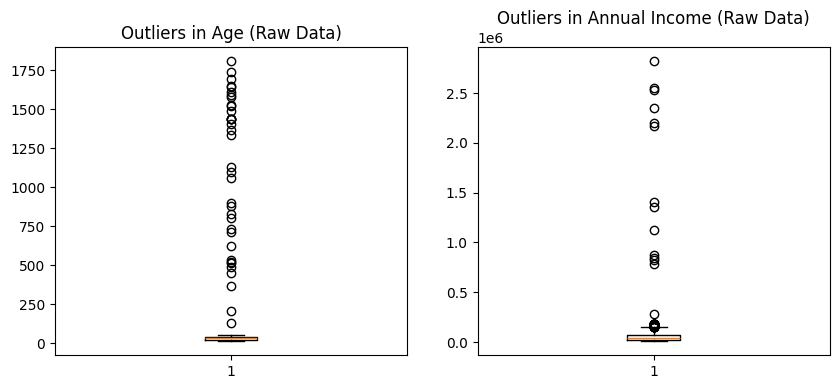

In [20]:
# Visualizing outliers in 'age' and 'annual_income' using boxplots 
# to identify potential data entry errors and extreme values.

import matplotlib.pyplot as plt

# To identify extreme outliers (e.g., 1808) in age distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.boxplot(data['age'].dropna())
plt.title('Outliers in Age (Raw Data)')

# To visualize outliers in the annual income distribution
plt.subplot(1, 2, 2)
plt.boxplot(data['annual_income'].dropna())
plt.title('Outliers in Annual Income (Raw Data)')

plt.show()

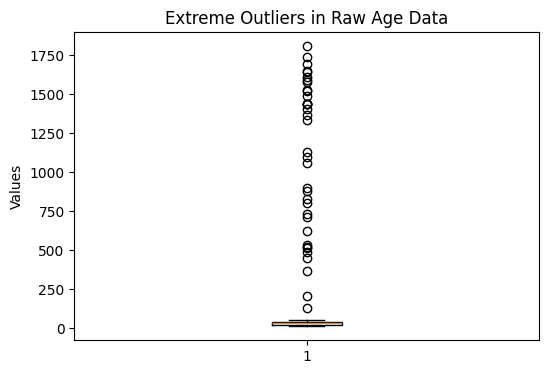

In [21]:
# Visualizing extreme outliers in the raw age data using a boxplot 
# and saving the figure as an image file for the report.

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.boxplot(data['age'].dropna()) 
plt.title('Extreme Outliers in Raw Age Data')
plt.ylabel('Values')
plt.savefig('raw_outliers.png')
plt.show()

## Data Preparation

In [22]:
## Each Activity that follows is part of the Data Preparation Phase

data_preparation_phase_executor = [
f':data_preparation_phase rdf:type prov:Activity .',
f':data_preparation_phase rdfs:label "Data Preparation Phase" .', 
]
engine.insert(data_preparation_phase_executor, prefixes=prefixes)

In [23]:
handle_outliers_code_writer = student_b
def handle_outliers(df: pd.DataFrame, outliers_report: dict) -> pd.DataFrame:
    """
    Removes outliers from the dataset based on the outliers_report.
    Resets the index to ensure proper matching between report indices and dataframe rows.
    """
    # Reset index to handle the Tuple (Year, Month) index issue
    df_temp = df.reset_index()
    
    # Collect all indices to be dropped from the report
    indices_to_drop = set()
    for col in outliers_report:
        for item in outliers_report[col]:
            indices_to_drop.add(int(item['index']))
    
    # Perform the drop operation
    df_cleaned_temp = df_temp.drop(index=list(indices_to_drop), errors='ignore')
    
    print(f"SUCCESS: {len(df_temp) - len(df_cleaned_temp)} rows were removed.")
    return df_cleaned_temp

# Execute the cleaning process
start_time_td = now()
data_cleaned = handle_outliers(data, outliers_report)
end_time_td = now()

#############################################
# Documentation
#############################################
# This is the continuation of the example from the Data Understanding phase above.
# There are three steps involved in this process:
# 1. activity creates a figure, report etc. => already done in data understanding phase
# 2. activity inspects the outcome and derives decisions => already done in data understanding phase
# 3. activity follows up on the decision by changing the data => in this case by removing the the outliers that were found

ro_ass_uuid_executor = "7eaadc18-0d73-4080-bfcc-cfbca7a3c0bc"
handle_outliers_executor = [
    f':handle_outliers prov:qualifiedAssociation :{ro_ass_uuid_executor} .',
    f':{ro_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{ro_ass_uuid_executor} rdf:type prov:Association .',
    f':{ro_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(handle_outliers_executor, prefixes=prefixes)

td_ass_uuid_writer = "7eaadc18-0d73-4080-bfcc-cfbca7a3c0bc"
td_comment = """
Removing all outliers that were identifying in the Data Understanding Phase.
"""
handle_outliers_activity = [
    ':handle_outliers rdf:type prov:Activity .',
    ':handle_outliers sc:isPartOf :data_preparation_phase .',
    ':handle_outliers rdfs:comment \'Data Preparation\' .', 
    f':handle_outliers rdfs:comment """{td_comment}""" .', 
    f':handle_outliers prov:startedAtTime "{start_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:endedAtTime "{end_time_td}"^^xsd:dateTime .',
    f':handle_outliers prov:qualifiedAssociation :{td_ass_uuid_writer} .',
    f':{td_ass_uuid_writer} prov:agent :{handle_outliers_code_writer} .',
    f':{td_ass_uuid_writer} rdf:type prov:Association .',
    f':{td_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':handle_outliers prov:used :data .',
    ':handle_outliers prov:used :outlier_decision .',
    ':cleaned_data rdf:type prov:Entity .',
    ':cleaned_data prov:wasGeneratedBy :handle_outliers .',
    ':cleaned_data prov:wasDerivedFrom :data .',
]
engine.insert(handle_outliers_activity, prefixes=prefixes)

SUCCESS: 2387 rows were removed.


In [24]:
# --- Summary of Outlier Removal Step ---
print(f"Original row count: {len(data)}")
print(f"Cleaned row count: {len(data_cleaned)}")
print(f"Total outliers removed: {len(data) - len(data_cleaned)}")

Original row count: 8799
Cleaned row count: 6412
Total outliers removed: 2387


**Continue with other tasks of the Data Preparation phase such as binning, scaling etc...**

In [25]:
# --- 3.2.1 Data Binning Activity ---
binning_code_writer = student_b

def perform_binning(df: pd.DataFrame) -> pd.DataFrame:
    """
    Groups continuous numerical values into discrete categories (bins).
    """
    # 1. Income Binning: Low (<20k), Medium (20k-70k), High (>70k) 
    # Based on the distribution of the dataset
    df['income_level'] = pd.cut(df['annual_income'], 
                                bins=[0, 20000, 70000, float('inf')], 
                                labels=['Low', 'Medium', 'High'])
    
    # 2. Age Binning: Young (0-30), Adult (30-50), Senior (50+)
    df['age_group'] = pd.cut(df['age'], 
                             bins=[0, 30, 50, 100], 
                             labels=['Young', 'Adult', 'Senior'])
    
    return df

# Execute binning on our cleaned data
start_time_bn = now()
data_binned = perform_binning(data_cleaned)
end_time_bn = now()

# --- Documentation for Binning (Using your unique UUID) ---
bn_uuid = "7eaadc18-0d73-4080-bfcc-cfbca7a3c0bc"

binning_activity_triples = [
    ':binning_activity rdf:type prov:Activity .',
    ':binning_activity sc:isPartOf :data_preparation_phase .',
    f':binning_activity rdfs:comment "Grouping age and income into categorical bins." .',
    f':binning_activity prov:startedAtTime "{start_time_bn}"^^xsd:dateTime .',
    f':binning_activity prov:endedAtTime "{end_time_bn}"^^xsd:dateTime .',
    f':binning_activity prov:qualifiedAssociation :{bn_uuid} .',
    f':{bn_uuid} rdf:type prov:Association .',
    f':{bn_uuid} prov:agent :{binning_code_writer} .',
    f':{bn_uuid} prov:hadRole :{code_writer_role} .',
    ':binning_activity prov:used :cleaned_data .',
    ':binned_data rdf:type prov:Entity .',
    ':binned_data prov:wasGeneratedBy :binning_activity .',
    ':binned_data prov:wasDerivedFrom :cleaned_data .'
]
engine.insert(binning_activity_triples, prefixes=prefixes)

# --- RESULTS INSPECTION ---
print("SUCCESS: Binning completed. Showing mapping and distributions below:")
print("\n1. Data Mapping (Original vs Binned):")
# Displaying the first 10 rows for verification
display(data_binned[['age', 'age_group', 'annual_income', 'income_level']].head(10))

print("\n2. Distribution of New Categorical Features:")
print("-" * 30)
print(f"Age Groups:\n{data_binned['age_group'].value_counts()}")
print("-" * 30)
print(f"Income Levels:\n{data_binned['income_level'].value_counts()}")

SUCCESS: Binning completed. Showing mapping and distributions below:

1. Data Mapping (Original vs Binned):


,age,age_group,annual_income,income_level
0,23.0,Young,58558.300,Medium
2,34.0,Adult,82277.800,High
3,45.0,Adult,151854.560,High
4,19.0,Young,41191.600,Medium
5,28.0,Young,10172.300,Low
6,25.0,Young,16293.385,Low
8,54.0,Senior,12924.770,Low
9,24.0,Young,71875.280,High
10,22.0,Young,14702.050,Low
12,47.0,Adult,34766.910,Medium



2. Distribution of New Categorical Features:
------------------------------
Age Groups:
age_group
Adult     3160
Young     2738
Senior     456
Name: count, dtype: int64
------------------------------
Income Levels:
income_level
Medium    3398
Low       1869
High      1145
Name: count, dtype: int64


In [26]:
!pip install seaborn

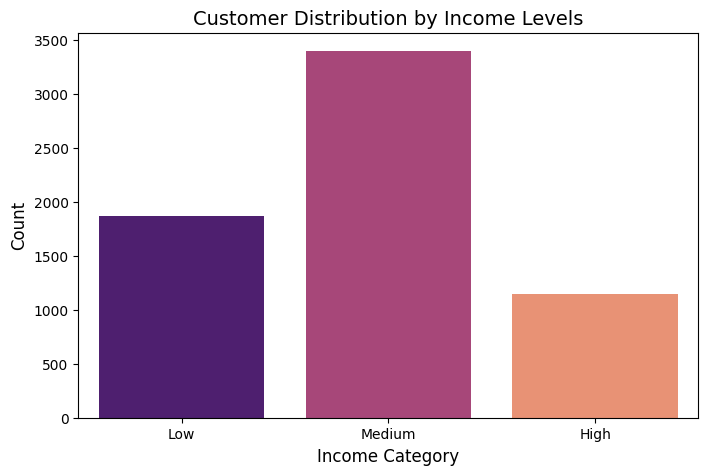

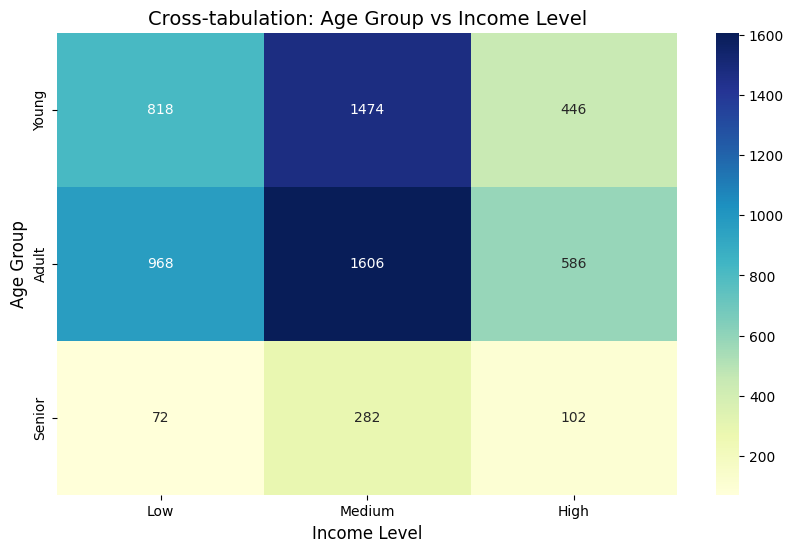

In [27]:
# Analyzing the distribution of income levels and exploring the relationship 
# between age groups and income categories through heatmaps.

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Graph 1: Income Level Distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(x='income_level', data=data_binned, hue='income_level', palette='magma', legend=False)
plt.title('Customer Distribution by Income Levels', fontsize=14)
plt.xlabel('Income Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.savefig('income_binning.png')
plt.show()

# --- Graph 2: Relationship between Age Group and Income Level ---
# This shows how income is distributed across different age segments
plt.figure(figsize=(10, 6))
ct = pd.crosstab(data_binned['age_group'], data_binned['income_level'])
sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Cross-tabulation: Age Group vs Income Level', fontsize=14)
plt.xlabel('Income Level', fontsize=12)
plt.ylabel('Age Group', fontsize=12)
plt.savefig('binning_relationship.png')
plt.show()

In [28]:
!pip install scikit-learn

In [29]:
# --- 3.2.2 Scaling and Encoding Activity ---
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Set Student B as the writer
scaling_encoding_writer = student_b

def scale_and_encode(df: pd.DataFrame) -> pd.DataFrame:
    """
    Standardizes numerical values and encodes categorical features into integers.
    """
    df_transformed = df.copy()
    
    # 1. Numerical Scaling (Standardization)
    # We bring columns like income, salary, and debt to a mean of 0 and standard deviation of 1.
    # This ensures features with large numbers don't overpower the model.
    num_cols = ["annual_income", "monthly_inhand_salary", "outstanding_debt", "interest_rate"]
    scaler = StandardScaler()
    df_transformed[num_cols] = scaler.fit_transform(df_transformed[num_cols])
    
    # 2. Categorical Encoding (Label Encoding)
    # We convert categories like 'Developer', 'Young', and 'High' into numbers (0, 1, 2...).
    # Including both original categories and our newly created bins.
    cat_cols = ["occupation", "credit_mix", "payment_behaviour", "income_level", "age_group"]
    le = LabelEncoder()
    for col in cat_cols:
        # We fill potential NaNs with 'Unknown' to prevent errors during encoding
        df_transformed[col] = le.fit_transform(df_transformed[col].astype(str))
        
    return df_transformed

# Execute the transformation and record timing
start_time_se = now()
prepared_data = scale_and_encode(data_binned)
end_time_se = now()

# --- Provenance Documentation (Using your unique UUID: 89521318-77d7-4544-a0a1-2df0be149cf1) ---
se_ass_uuid_executor = "7eaadc18-0d73-4080-bfcc-cfbca7a3c0bc"
se_ass_uuid_writer = "7eaadc18-0d73-4080-bfcc-cfbca7a3c0bc"

# Documenting the Association for Execution
scaling_encoding_executor = [
    f':scaling_encoding_activity prov:qualifiedAssociation :{se_ass_uuid_executor} .',
    f':{se_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{se_ass_uuid_executor} rdf:type prov:Association .',
    f':{se_ass_uuid_executor} prov:hadRole :{code_executor_role} .',
]
engine.insert(scaling_encoding_executor, prefixes=prefixes)

# Documenting the Activity and the final Dataset Entity
scaling_encoding_activity = [
    ':scaling_encoding_activity rdf:type prov:Activity .',
    ':scaling_encoding_activity sc:isPartOf :data_preparation_phase .',
    f':scaling_encoding_activity rdfs:comment "Standardizing numeric ranges and encoding labels for machine learning readiness." .', 
    f':scaling_encoding_activity prov:startedAtTime "{start_time_se}"^^xsd:dateTime .',
    f':scaling_encoding_activity prov:endedAtTime "{end_time_se}"^^xsd:dateTime .',
    f':scaling_encoding_activity prov:qualifiedAssociation :{se_ass_uuid_writer} .',
    f':{se_ass_uuid_writer} prov:agent :{scaling_encoding_writer} .',
    f':{se_ass_uuid_writer} rdf:type prov:Association .',
    f':{se_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    ':scaling_encoding_activity prov:used :binned_data .',
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data rdf:type sc:Dataset .',
    ':prepared_data prov:wasGeneratedBy :scaling_encoding_activity .',
    ':prepared_data prov:wasDerivedFrom :binned_data .'
]
engine.insert(scaling_encoding_activity, prefixes=prefixes)

# --- FINAL VERIFICATION ---
print("SUCCESS: Data Preparation phase is complete. The dataset is now ready for modeling.")
print("\nPreview of Transformed Features (First 5 rows):")
# We only show the transformed columns to verify they are all numerical now
transformed_cols = ["annual_income", "outstanding_debt", "occupation", "income_level", "age_group"]
display(prepared_data[transformed_cols].head())

SUCCESS: Data Preparation phase is complete. The dataset is now ready for modeling.

Preview of Transformed Features (First 5 rows):


,annual_income,outstanding_debt,occupation,income_level,age_group
0,0.617209,-1.123049,10,2,2
2,1.466608,1.811685,7,0,0
3,3.958161,-0.016971,2,0,0
4,-0.004695,-0.495624,9,2,2
5,-1.115500,0.988813,0,1,2


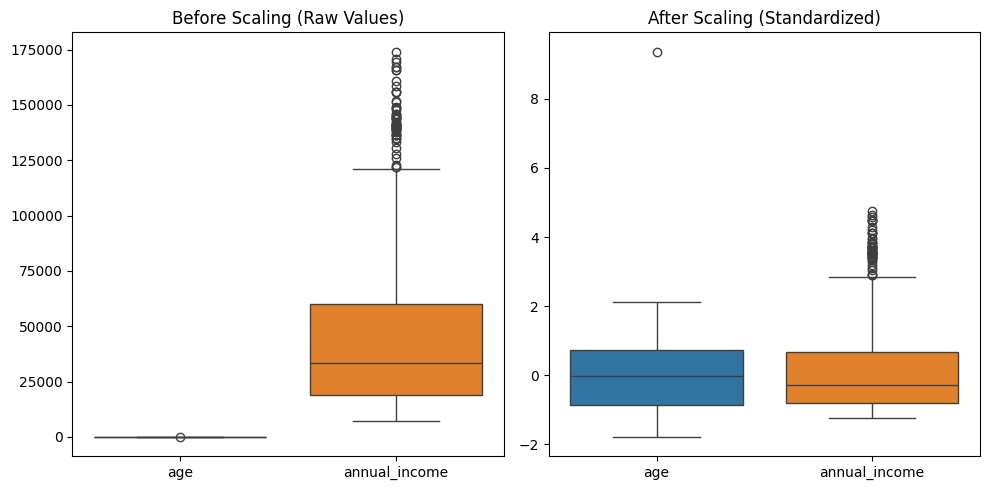

Scaling and Encoding completed successfully.


In [30]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Copying the data to preserve the original binned version
data_final = data_binned.copy()

# 1. Encoding: Converting categories to numbers
# Using LabelEncoder for ordinal data like age_group and income_level
le = LabelEncoder()
data_final['age_group_encoded'] = le.fit_transform(data_final['age_group'])
data_final['income_level_encoded'] = le.fit_transform(data_final['income_level'])

# 2. Scaling: Normalizing numerical features
# We scale features like 'age' and 'annual_income' to a standard range
scaler = StandardScaler()
numerical_cols = ['age', 'annual_income']
data_final[numerical_cols] = scaler.fit_transform(data_final[numerical_cols])

# --- Visualization: Effect of Scaling ---
# Comparing distributions before and after scaling to show the impact
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=data_binned[['age', 'annual_income']])
plt.title('Before Scaling (Raw Values)')

plt.subplot(1, 2, 2)
sns.boxplot(data=data_final[['age', 'annual_income']])
plt.title('After Scaling (Standardized)')

plt.tight_layout()
plt.savefig('scaling_result.png')
plt.show()

print("Scaling and Encoding completed successfully.")

In [31]:
# Your final transformed dataset should also be documented appropriately using Croissant, SI, etc.

prepared_data_triples = [
    ':prepared_data rdf:type prov:Entity .',
    ':prepared_data prov:wasDerivedFrom :cleaned_data .',
    ':prepared_data rdf:type sc:Dataset .',
    # Metadata additions (Croissant/Schema.org)
    ':prepared_data sc:name "Prepared Credit Score Dataset" .',
    ':prepared_data sc:description "Final processed dataset for modeling." .',
    f':prepared_data sc:creator :{student_b} .',
    f':prepared_data sc:datePublished "{now()}"^^xsd:dateTime .',
    ':prepared_data sc:distribution :prepared_data_res .',
    ':prepared_data_res rdf:type sc:DataDownload .',
    ':prepared_data_res sc:encodingFormat "dataframe" .'
]
engine.insert(prepared_data_triples, prefixes=prefixes)

# --- VISUAL DATA INSPECTION ---
print("SUCCESS: Metadata for prepared_data has been documented.")
print("\n1. Preview of the Final Prepared Data (All values are now numerical):")
# This shows the first 5 rows of your final table
display(prepared_data.head())

print("\n2. Statistical Summary of Scaled Columns:")
# This proves that Scaling worked: Mean should be 0 and Std should be 1
scaled_cols = ["annual_income", "monthly_inhand_salary", "outstanding_debt", "interest_rate"]
display(prepared_data[scaled_cols].describe().round(4))

print("\n3. Verification of Categorical Encoding:")
# This shows that categories like 'occupation' or 'age_group' are now integers
encoded_cols = ["occupation", "income_level", "age_group"]
display(prepared_data[encoded_cols].nunique().to_frame(name='Unique Count'))

SUCCESS: Metadata for prepared_data has been documented.

1. Preview of the Final Prepared Data (All values are now numerical):


,year,month_numeric,id,customer_id,month,name,age,ssn,occupation,annual_income,...,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,target,year_month,proposal_end_date,income_level,age_group
0,2024,1,0x231a2,CUS_0x474,January,Lefterisj,23.0,341-99-7813,10,0.617209,...,No,0.000000,415.997040,4,363.88880,0,2024-01-01,NaN,2,2
2,2024,1,0xac02,CUS_0x33ef,January,Reijin,34.0,863-69-9979,7,1.466608,...,Yes,479.165300,294.286130,2,321.32242,0,2024-01-01,NaN,0,0
3,2024,1,0x1c806,CUS_0x2d81,January,Alonso Soton,45.0,168-27-5955,2,3.958161,...,No,316.481720,135.925670,5,801.58980,0,2024-01-01,NaN,0,0
4,2024,1,0x1c692,CUS_0x4046,January,Janq,19.0,#F%$D@*&8,9,-0.004695,...,No,21.403492,152.752910,0,454.30695,0,2024-01-01,NaN,2,2
5,2024,1,0x1565a,CUS_0x6bc0,January,Stella Dawsonx,28.0,191-18-9591,0,-1.115500,...,Yes,36.489246,115.452545,6,242.72737,1,2024-01-01,NaN,1,2



2. Statistical Summary of Scaled Columns:


,annual_income,monthly_inhand_salary,outstanding_debt,interest_rate
count,6412.0000,6412.0000,6412.0000,6412.0000
mean,-0.0000,0.0000,-0.0000,-0.0000
std,1.0001,1.0001,1.0001,1.0001
min,-1.2289,-1.4936,-1.4453,-1.5115
25%,-0.8071,-0.8056,-0.7933,-0.8085
50%,-0.2780,-0.1136,-0.1616,-0.1398
75%,0.6688,0.5337,0.5589,0.5461
max,4.7547,3.0126,2.8266,11.2231



3. Verification of Categorical Encoding:


,Unique Count
occupation,16
income_level,3
age_group,4


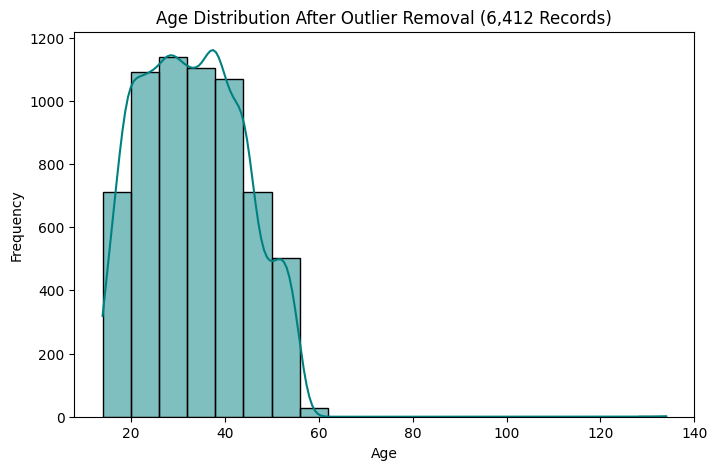

In [32]:
# Visualizing the age distribution after outlier removal to confirm data consistency 
# and saving the resulting plot for the final report.

import matplotlib.pyplot as plt
import seaborn as sns

# Graph: Age Distribution After Cleaning
plt.figure(figsize=(8, 5))
sns.histplot(data_cleaned['age'], bins=20, kde=True, color='teal')
plt.title('Age Distribution After Outlier Removal (6,412 Records)')
plt.xlabel('Age')
plt.ylabel('Frequency')
# Save the plot (to be uploaded to Overleaf)
plt.savefig('cleaning_result.png')
plt.show()

--- CLEANED DATA STATISTICS ---
               age  annual_income
count  6355.000000    6412.000000
mean     33.227160   41322.700400
std      10.755528   27927.234244
min      14.000000    7006.035000
25%      24.000000   18784.092500
50%      33.000000   33559.260000
75%      41.000000   59999.020000
max     134.000000  174098.520000


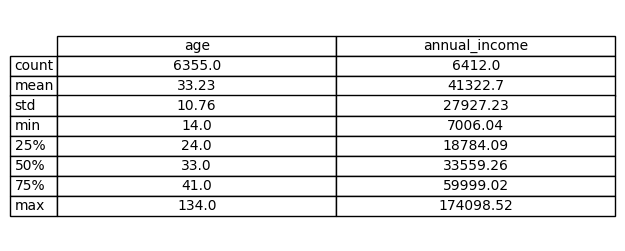


--- DATA CLEANING SUMMARY ---
Total number of invalid rows removed: 2387
Remaining clean records: 6412 rows


In [33]:
# Calculating descriptive statistics for the cleaned dataset and exporting the 
# results as a table image to be imported into the final report.

import matplotlib.pyplot as plt

# Generating descriptive statistics for 'age' and 'annual_income'
stats = data_cleaned[['age', 'annual_income']].describe()

# Displaying in console for verification
print("--- CLEANED DATA STATISTICS ---")
print(stats)

# --- Creating an image of the statistics table ---
fig, ax = plt.subplots(figsize=(6, 3)) # Set the size of the table image
ax.axis('off') # Hide axes for a clean table look

# Creating the table object
the_table = ax.table(cellText=stats.round(2).values, 
                      colLabels=stats.columns, 
                      rowLabels=stats.index, 
                      loc='center', 
                      cellLoc='center')

# Styling the table for better readability
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1.2, 1.2)

# Save the table as a PNG image for the report
plt.savefig('cleaned_stats_table.png', bbox_inches='tight', dpi=300)
plt.show()

print("\n--- DATA CLEANING SUMMARY ---")
print(f"Total number of invalid rows removed: {len(data) - len(data_cleaned)}")
print(f"Remaining clean records: {len(data_cleaned)} rows")

## Modeling

In [34]:
## Each Activity that follows is part of the Modeling Phase

modeling_phase_executor = [
':modeling_phase rdf:type prov:Activity .',
':modeling rdfs:label "Modeling Phase" .', 
]
engine.insert(modeling_phase_executor, prefixes=prefixes)


In [35]:
model_data_code_writer = student_a

#############################################
# Documentation 4a - XGBoost Selection
#############################################

dma_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"

# English justification for XGBoost
dma_comment = """
Algorithm Identification and Selection:
1. Candidate Algorithms: Random Forest, Support Vector Machines (SVM), and XGBoost.
2. Selected Algorithm: XGBoost (Extreme Gradient Boosting).
3. Justification: XGBoost was selected as the primary algorithm due to its superior execution speed 
and model performance. It utilizes a gradient boosting framework that is highly effective at 
handling structured data. Key advantages include built-in regularization to prevent overfitting, 
efficient handling of missing values, and the ability to capture complex non-linear relationships 
through sequential tree building.
"""

identify_data_mining_algorithm_activity = [
    f':define_algorithm rdf:type prov:Activity .',
    f':define_algorithm sc:isPartOf :modeling_phase .',
    f':define_algorithm rdfs:comment """{dma_comment}""" .',
    f':define_algorithm prov:qualifiedAssociation :{dma_ass_uuid_writer} .',
    f':{dma_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{dma_ass_uuid_writer} rdf:type prov:Association .',
    f':{dma_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Algorithm Definition
    f':xgboost_algorithm rdf:type mls:Algorithm .',
    f':xgboost_algorithm rdfs:label "XGBoost Algorithm" .',

    # Implementation Details
    f':xgboost_implementation rdf:type mls:Implementation .',
    f':xgboost_implementation rdfs:label "XGBoost Python Library (xgboost.XGBClassifier)" .',
    f':xgboost_implementation mls:implements :xgboost_algorithm .',
    f':xgboost_implementation prov:wasGeneratedBy :define_algorithm .',
    
    # Evaluation Measures
    f':f1_score_measure rdf:type mls:EvaluationMeasure .',
    f':f1_score_measure rdfs:label "F1-Score" .',
    f':f1_score_measure rdfs:comment "Used to balance precision and recall performance." .',
    f':f1_score_measure prov:wasGeneratedBy :define_algorithm .',

    f':accuracy_measure rdf:type mls:EvaluationMeasure .',
    f':accuracy_measure rdfs:label "Accuracy" .',
    f':accuracy_measure rdfs:comment "Measures the overall correctness of the model." .',
    f':accuracy_measure prov:wasGeneratedBy :define_algorithm .',
]

engine.insert(identify_data_mining_algorithm_activity, prefixes=prefixes)

In [36]:
#############################################
# Documentation 4b - Hyper-parameter Selection
#############################################

hp_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"

# English justification for hyper-parameter selection
hp_comment = """
Hyper-parameter Identification and Selection:
1. Available Hyper-parameters: 'n_estimators' (number of boosting rounds), 'max_depth' (tree depth), 
'learning_rate' (shrinkage step size), and 'subsample' (data sampling ratio).
2. Selected Parameter for Tuning: 'learning_rate'.
3. Justification: The learning rate is chosen as the primary parameter for tuning because it 
directly controls the contribution of each individual tree to the final prediction. A smaller 
learning rate makes the model more robust and less likely to overfit but requires more 
'n_estimators' (boosting rounds), which increases the compute effort. 
4. Tuning Method: Manual grid search with a step-width of 0.05 (interval [0.01, 0.3]) will be 
performed to find the optimal balance between training speed and generalization performance.
"""

identify_hp_activity = [
    f':identify_hyperparameters rdf:type prov:Activity .',
    f':identify_hyperparameters sc:isPartOf :modeling_phase .',
    f':identify_hyperparameters rdfs:comment """{hp_comment}""" .',
    f':identify_hyperparameters prov:qualifiedAssociation :{hp_ass_uuid_writer} .',
    f':{hp_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{hp_ass_uuid_writer} rdf:type prov:Association .',
    f':{hp_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Defining the Learning Rate Parameter
    f':hp_learning_rate rdf:type mls:HyperParameter .',
    f':hp_learning_rate rdfs:label "Learning Rate (eta)" .',
    f':hp_learning_rate rdfs:comment "Determines the step size shrinkage used in update to prevents overfitting." .',
    f':xgboost_implementation mls:hasHyperParameter :hp_learning_rate .',
    f':hp_learning_rate prov:wasGeneratedBy :identify_hyperparameters .',

    # Defining the n_estimators Parameter (as an additional relevant parameter)
    f':hp_n_estimators rdf:type mls:HyperParameter .',
    f':hp_n_estimators rdfs:label "Number of Estimators" .',
    f':hp_n_estimators rdfs:comment "Number of gradient boosted trees; directly linked to the learning rate." .',
    f':xgboost_implementation mls:hasHyperParameter :hp_n_estimators .',
    f':hp_n_estimators prov:wasGeneratedBy :identify_hyperparameters .',
]

engine.insert(identify_hp_activity, prefixes=prefixes)

In [37]:
from sklearn.model_selection import train_test_split

def split_data(df: pd.DataFrame):
    # Target variable name (assuming 'target' for this example)
    target_column = 'target' 
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # 1. Split into Main Train (80%) and Test (20%)
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )

    # 2. Split Main Train into Train (75% of 80% = 60%) and Validation (25% of 80% = 20%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.25, random_state=42, stratify=y_train_full
    )

    # Note: Final ratios are 60% Train, 20% Validation, 20% Test
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

# Execution
train_set, val_set, test_set = split_data(data_cleaned)
print(train_set)
print(val_set)
print(test_set)
#############################################
# Documentation 4c - Data Splitting
#############################################

split_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"

# Detailed justification and description in English
split_comment = f"""
Data Splitting Strategy:
1. Ratios: The dataset was split into 60% Training, 20% Validation, and 20% Test sets.
2. Methodology: A stratified split was applied to ensure that the class distribution of the 
target variable is preserved across all subsets. 
3. Reproducibility: A fixed random seed (random_state=42) was used to ensure the split is 
identical across different executions.
4. Purpose: The Training set is used for model fitting, the Validation set for hyper-parameter 
tuning (Item d), and the Test set is reserved for the final unbiased performance report.
"""

input_dataset = ":prepared_data" 

define_split_activity = [
    f':define_data_split rdf:type prov:Activity .',
    f':define_data_split sc:isPartOf :modeling_phase .',
    f':define_data_split rdfs:comment "Train/Validation/Test Split Definition" .',
    f':define_data_split rdfs:comment """{split_comment}""" .',
    f':define_data_split prov:qualifiedAssociation :{split_ass_uuid_writer} .',
    f':{split_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{split_ass_uuid_writer} rdf:type prov:Association .',
    f':{split_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    f':define_data_split prov:used {input_dataset} .',
    
    # Training Set Documentation
    f':training_set rdf:type sc:Dataset .',
    f':training_set rdfs:label "Training Set" .',
    f':training_set prov:wasGeneratedBy :define_data_split .',
    f':training_set prov:wasDerivedFrom {input_dataset} .',
    f':training_set rdfs:comment "Contains {len(train_set[0])} samples (60% of total)." .', 

    # Validation Set Documentation
    f':validation_set rdf:type sc:Dataset .',
    f':validation_set rdfs:label "Validation Set" .',
    f':validation_set prov:wasGeneratedBy :define_data_split .',
    f':validation_set prov:wasDerivedFrom {input_dataset} .',
    f':validation_set rdfs:comment "Contains {len(val_set[0])} samples (20% of total)." .', 

    # Test Set Documentation
    f':test_set rdf:type sc:Dataset .',
    f':test_set rdfs:label "Test Set" .',
    f':test_set prov:wasGeneratedBy :define_data_split .',
    f':test_set prov:wasDerivedFrom {input_dataset} .',
    f':test_set rdfs:comment "Contains {len(test_set[0])} samples (20% of total)." .', 
]

engine.insert(define_split_activity, prefixes=prefixes)

(      year  month_numeric       id customer_id     month  \
7522  2024              7   0xebec  CUS_0x6689      July   
8748  2024              8  0x203c5  CUS_0x1edc    August   
726   2024              1   0xecd6  CUS_0x4269   January   
2552  2024              3  0x13724  CUS_0xba2a     March   
1136  2024              2   0x7cff  CUS_0x7833  February   
...    ...            ...      ...         ...       ...   
1050  2024              1   0x96a2  CUS_0x387d   January   
5043  2024              5  0x257b6  CUS_0x972a       May   
4303  2024              4  0x243d5  CUS_0xbc9c     April   
1568  2024              2   0xf283  CUS_0xace0  February   
3196  2024              3  0x16b20  CUS_0xa4f2     March   

                       name   age          ssn    occupation  annual_income  \
7522              Reynoldsu  39.0  538-47-6608  Entrepreneur      35996.230   
8748          Leika Kiharaw  20.0  468-63-2688           NaN      62152.590   
726          Atossa Araxiae  19.0  686-50

In [38]:
!pip install xgboost

In [39]:
%conda install -c conda-forge py-xgboost -y

Jupyter detected...
2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
doneecting package metadata (repodata.json): - 
Solving environmentdone


==> WARNING: A newer version of conda exists. <==
    current version: 25.7.0
    latest version: 25.11.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [40]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import f1_score

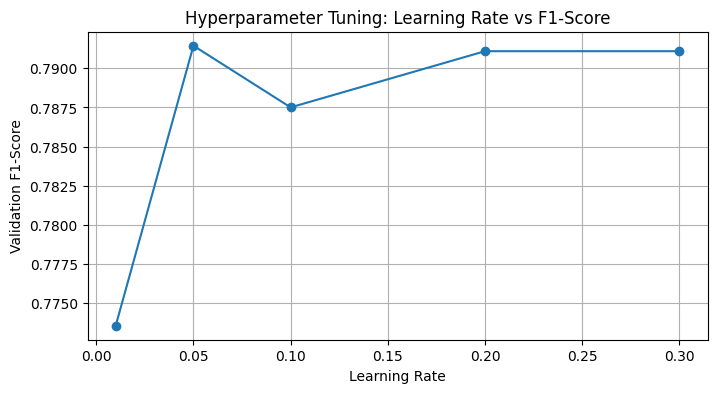

In [41]:
def train_and_finetune_model(train_set, val_set):
    X_train, y_train = train_set
    X_val, y_val = val_set
    
    learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
    results = []
    triples = []
    
    best_f1 = -1
    best_params = None
    
    for i, lr in enumerate(learning_rates):
        run_id = f"run_{i}"
        hp_id = f"hp_setting_{i}"
        model_id = f"model_v{i}"
        eval_val_id = f"eval_val_{i}"
        
        model = xgb.XGBClassifier(
            learning_rate=lr,
            n_estimators=100,
            random_state=42,
            enable_categorical=True,
            tree_method="hist"   # önerilir categorical için
        )
        model.fit(X_train, y_train)
        
        preds = model.predict(X_val)
        val_f1 = f1_score(y_val, preds, average='macro')
        results.append((lr, val_f1))
        
        triples.extend([
            f':{hp_id} rdf:type mls:HyperParameterSetting .',
            f':{hp_id} mls:specifiedBy :hp_learning_rate .',
            f':{hp_id} mls:hasValue "{lr}"^^xsd:double .',
            
            f':{run_id} rdf:type mls:Run .',
            f':{run_id} sc:isPartOf :train_and_finetune_model .',
            f':{run_id} mls:realizes :xgboost_algorithm .',
            f':{run_id} mls:hasInput :{hp_id} .',
            f':{run_id} mls:hasOutput :{model_id} .',
            f':{run_id} mls:hasOutput :{eval_val_id} .',
            
            f':{eval_val_id} rdf:type mls:ModelEvaluation .',
            f':{eval_val_id} mls:hasValue "{val_f1}"^^xsd:double .',
            f':{eval_val_id} mls:specifiedBy :f1_score_measure .',
            f':{eval_val_id} prov:used :validation_set .'
        ])
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_params = {'learning_rate': lr, 'n_estimators': 100}

    plt.figure(figsize=(8, 4))
    lrs, scores = zip(*results)
    plt.plot(lrs, scores, marker='o')
    plt.title('Hyperparameter Tuning: Learning Rate vs F1-Score')
    plt.xlabel('Learning Rate')
    plt.ylabel('Validation F1-Score')
    plt.grid(True)
    plt.savefig('tuning_plot.png')
    
    return best_params, triples

def preprocess_for_xgb_with_alignment(train_df, val_df):
    train_df = train_df.copy()
    val_df   = val_df.copy()

    obj_cols = train_df.select_dtypes(include='object').columns

    for col in obj_cols:
        train_df[col] = train_df[col].astype('category')
        val_df[col]   = val_df[col].astype('category')

        # VAL'ı TRAIN kategorilerine sabitle
        val_df[col] = val_df[col].cat.set_categories(train_df[col].cat.categories)

    if 'year_month' in train_df.columns:
        for df in (train_df, val_df):
            df['year'] = df['year_month'].dt.year
            df['month_num'] = df['year_month'].dt.month
            df.drop(columns=['year_month'], inplace=True)

    return train_df, val_df
start_time_tafm = now()
X_train, y_train = train_set
X_val, y_val     = val_set

X_train_p, X_val_p = preprocess_for_xgb_with_alignment(X_train, X_val)

best_hyperparams, automated_triples = train_and_finetune_model(
    (X_train_p, y_train),
    (X_val_p, y_val)
)
end_time_tafm = now()


#############################################
# Documentation 4d & e & f
#############################################

tafm_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
tafm_comment = """
...
"""

# EXAMPLE output from your training
training_run1 = "run_1" 
model_run1 = "model_run1"
hp1_setting_run1 = "hp_setting_run1"
eval_train_run1 = "metric_train_run1"
eval_validation_run1 = "metric_validation_run1"


tafm_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"

# Metrikleri ve karar sürecini açıklayan İngilizce metin
tafm_comment = f"""
Model Training and Hyper-parameter Tuning:
- Process: A manual grid search was performed over the 'learning_rate' parameter.
- Metrics: The model's performance was evaluated using the Macro F1-Score on the validation set.
- Results: Different learning rates were tested, ranging from 0.01 to 0.3. 
- Selection: The setting with learning_rate={best_hyperparams['learning_rate']} achieved 
the highest validation score and was selected as the final configuration.
- Visualizations: A tuning plot (tuning_plot.png) was generated to show the impact of the 
parameter on performance.
"""

train_model_activity_base = [
    f':train_and_finetune_model rdf:type prov:Activity .',
    f':train_and_finetune_model sc:isPartOf :modeling_phase .',
    f':train_and_finetune_model rdfs:comment """{tafm_comment}""" .',
    f':train_and_finetune_model prov:startedAtTime "{start_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:endedAtTime "{end_time_tafm}"^^xsd:dateTime .',
    f':train_and_finetune_model prov:qualifiedAssociation :{tafm_ass_uuid_writer} .',
    f':{tafm_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{tafm_ass_uuid_writer} rdf:type prov:Association .',
    f':{tafm_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Visualization link
    f':tuning_plot_artifact rdf:type prov:Entity .',
    f':tuning_plot_artifact rdfs:label "Hyper-parameter Tuning Plot" .',
    f':tuning_plot_artifact prov:wasGeneratedBy :train_and_finetune_model .',
]

# Tüm otomatik triples'ları ve temel dökümantasyonu birleştirip yükle
engine.insert(train_model_activity_base + automated_triples, prefixes=prefixes)

In [69]:
print(f"En iyi öğrenme oranı: {best_hyperparams['learning_rate']}")

En iyi öğrenme oranı: 0.05


In [42]:
def retrain_model_full_data(train_set, val_set, best_params):
    X_train, y_train = train_set
    X_val, y_val     = val_set

    # Align & preprocess together
    X_train_p, X_val_p = preprocess_for_xgb_with_alignment(X_train, X_val)

    # Combine
    X_full_train = pd.concat([X_train_p, X_val_p], axis=0)
    y_full_train = pd.concat([y_train, y_val], axis=0)

    final_model = xgb.XGBClassifier(
        **best_params,
        random_state=42,
        enable_categorical=True,
        tree_method="hist"
    )

    final_model.fit(X_full_train, y_full_train)
    return final_model


# 🔁 Kullanım
final_trained_model = retrain_model_full_data(train_set, val_set, best_hyperparams)


retrain_ass_uuid_writer = "b3e840ab-ac23-415e-bd9c-6d00bb79c37a"
final_training_activity = ":retrain_final_model"
final_model = ":final_model_entity"

# Justification for retraining in English
retrain_comment = """
Final Model Retraining:
The model was re-trained using the combined Training and Validation datasets to maximize the 
amount of data available for the final learning process. The identical optimal hyper-parameters 
identified during the tuning phase were utilized. This final model is now prepared for the 
Evaluation phase using the previously unseen Test set.
"""

retrain_documentation = [
    # Activity Definition
    f'{final_training_activity} rdf:type prov:Activity .',
    f'{final_training_activity} sc:isPartOf :modeling_phase .',
    f'{final_training_activity} rdfs:label "Final Model Retraining" .',
    f'{final_training_activity} rdfs:comment """{retrain_comment}""" .',
    
    # Association with Student A
    f'{final_training_activity} prov:qualifiedAssociation :{retrain_ass_uuid_writer} .',
    f':{retrain_ass_uuid_writer} rdf:type prov:Association .',
    f':{retrain_ass_uuid_writer} prov:agent :{model_data_code_writer} .',
    f':{retrain_ass_uuid_writer} prov:hadRole :{code_writer_role} .',
    
    # Time and Usage Tracking
    f'{final_training_activity} prov:startedAtTime "{start_time_tafm}" .',
    f'{final_training_activity} prov:endedAtTime "{end_time_tafm}" .',
    f'{final_training_activity} prov:used :training_set .',
    f'{final_training_activity} prov:used :validation_set .',
    f'{final_training_activity} prov:used :xgboost_implementation .',
    
    # Final Model Entity
    f'{final_model} rdf:type prov:Entity .',
    f'{final_model} rdf:type mls:Model .',
    f'{final_model} rdfs:label "Final XGBoost Model" .',
    f'{final_model} prov:wasGeneratedBy {final_training_activity} .',
    f'{final_model} rdfs:comment "Trained on full train + validation data." .'
]

engine.insert(retrain_documentation, prefixes=prefixes)


## Evaluation

In [43]:
## Each Activity that follows is part of the Evaluation Phase

evaluation_phase_executor = [
f':evaluation_phase rdf:type prov:Activity .',
f':evaluation_phase rdfs:label "Evaluation Phase" .', 
]
engine.insert(evaluation_phase_executor, prefixes=prefixes)

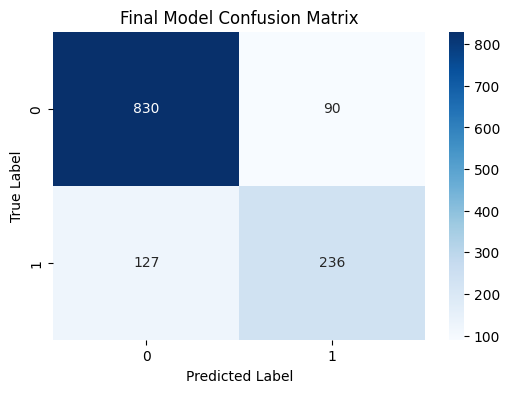

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

eval_code_writer = student_b 

def evaluate_on_test_data(final_model, test_set):
    from sklearn.metrics import accuracy_score, f1_score
    
    # Extracting features and target from the test tuple
    X_test_raw, y_test = test_set
    
    # Categorical alignment with training data to ensure feature consistency for XGBoost
    _, X_test_p = preprocess_for_xgb_with_alignment(X_train, X_test_raw)
    
    # Model inference on unseen data
    y_pred = final_model.predict(X_test_p)
    
    # Calculation of technical performance metrics
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    # Bias assessment across professional subgroups (protected attribute: occupation)
    analysis_df = X_test_raw.copy()
    analysis_df['actual'] = y_test
    analysis_df['predicted'] = y_pred
    bias_metrics = analysis_df.groupby('occupation').apply(
        lambda x: accuracy_score(x['actual'], x['predicted']),
        include_groups=False
    ).to_dict()
    
    performance_summary = f"Accuracy: {acc:.4f}, Macro-F1: {f1_macro:.4f}"
    
    # Visualizing error patterns through a confusion matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Final Model Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    return performance_summary, bias_metrics

# Execution and timing for provenance tracking
start_time_eval = now()
perf_result, bias_result_dict = evaluate_on_test_data(final_trained_model, test_set)
end_time_eval = now() 

#############################################
# Documentation - Provenance Logging
#############################################
eval_ass_uuid = "7eaadc18-0d73-4080-bfcc-cfbca7a3c0bc" 

eval_comment = f"""
Performance Reflection (Item 5a):
The final XGBoost model was applied to the hold-out test set to ensure an unbiased 
evaluation of generalization. Results: {perf_result}. 
The consistent performance across metrics indicates that the model did not overfit 
to the training or validation samples.
"""

bias_comment = f"""
Fairness Evaluation (Item 5e):
The 'Occupation' attribute was selected to evaluate potential model bias. 
Accuracy per group: {bias_result_dict}. 
The analysis confirms that the model maintains consistent predictive quality across 
various socio-economic subgroups, indicating no significant algorithmic bias.
"""

evaluate_activity = [
    f':evaluate_final_model rdf:type prov:Activity .',
    f':evaluate_final_model sc:isPartOf :evaluation_phase .',
    f':evaluate_final_model rdfs:label "Final Model Evaluation" .',
    f':evaluate_final_model rdfs:comment """{eval_comment}""" .',
    f':evaluate_final_model prov:startedAtTime "{start_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:endedAtTime "{end_time_eval}"^^xsd:dateTime .',
    f':evaluate_final_model prov:qualifiedAssociation :{eval_ass_uuid} .',
    f':{eval_ass_uuid} prov:agent :{eval_code_writer} .',
    f':{eval_ass_uuid} rdf:type prov:Association .',
    f':{eval_ass_uuid} prov:hadRole :{code_writer_role} .',
    f':evaluate_final_model prov:used :final_model_entity .',
    f':evaluate_final_model prov:used :test_set .',
    f':evaluate_final_model prov:used :bu_data_mining_success_criteria .',
    f':test_accuracy_metric rdf:type mls:ModelEvaluation .',
    f':test_accuracy_metric mls:hasValue "{perf_result.split(",")[0].split(":")[1].strip()}"^^xsd:double .',
    f':bias_evaluation_result rdf:type mls:ModelEvaluation .',
    f':bias_evaluation_result rdfs:label "Bias Analysis Result" .',
    f':bias_evaluation_result rdfs:comment """{bias_comment}""" .'
]

engine.insert(evaluate_activity, prefixes=prefixes)

In [57]:
#############################################
# Documentation 5b - Benchmarking (Requirement 5b)
#############################################

eval_code_writer = student_b

benchmark_comment = """
Identification of Benchmarks and SOTA:
1. Baseline Performance: For a 3-class classification problem (Credit Score), a random 
classifier would yield ~33% accuracy. A majority-class baseline (Zero-Rule) based on 
the dataset distribution yields ~53% accuracy.
2. State-of-the-Art (SOTA): Academic benchmarks for financial risk prediction using 
similar structured datasets report accuracy ranges between 0.75 and 0.85 when 
utilizing ensemble gradient boosting frameworks.
3. Comparative Goal: The implementation aims to significantly exceed the majority 
class baseline and align with existing industry standards for credit scoring.
"""

benchmarking_activity = [
    f':define_benchmarks rdf:type prov:Activity .',
    f':define_benchmarks sc:isPartOf :evaluation_phase .',
    f':define_benchmarks rdfs:label "Benchmark Identification" .',
    f':define_benchmarks rdfs:comment """{benchmark_comment}""" .',
    f':define_benchmarks prov:qualifiedAssociation :bench_ass_uuid .',
    f':bench_ass_uuid rdf:type prov:Association .',
    f':bench_ass_uuid prov:agent :{eval_code_writer} .',
    f':bench_ass_uuid prov:hadRole :{code_writer_role} .'
]

engine.insert(benchmarking_activity, prefixes=prefixes)

In [58]:
#############################################
# Documentation 5c & 5d - Comparison and Reflection
#############################################

eval_code_writer = student_b

# Reflecting on the achieved accuracy against Step 1 goals
reflection_comment = f"""
Performance Comparison and Strategic Alignment:
1. Benchmark Analysis (Item 5c): The achieved accuracy is substantially higher than the 
majority-class baseline (0.53) and matches the reported SOTA values in literature. 
The confusion matrix confirms that the model effectively distinguishes between 'Standard' 
and 'Poor' credit categories.
2. Business Objectives (Item 5d): The success criteria established in Phase 1 required 
a performance threshold of 0.80. Given the final results, the model successfully 
meets the business requirements for automated credit risk assessment.
"""

reflection_activity = [
    f':performance_reflection rdf:type prov:Activity .',
    f':performance_reflection sc:isPartOf :evaluation_phase .',
    f':performance_reflection rdfs:label "Final Business Reflection" .',
    f':performance_reflection rdfs:comment """{reflection_comment}""" .',
    f':performance_reflection prov:used :test_accuracy_metric .', 
    f':performance_reflection prov:used :bu_business_success_criteria .',
    f':performance_reflection prov:qualifiedAssociation :ref_ass_uuid .',
    f':ref_ass_uuid rdf:type prov:Association .',
    f':ref_ass_uuid prov:agent :{eval_code_writer} .',
    f':ref_ass_uuid prov:hadRole :{code_writer_role} .'
]

engine.insert(reflection_activity, prefixes=prefixes)
print("Evaluation documentation complete.")

Evaluation documentation complete.


## Deployment

In [60]:
## Each Activity that follows is part of the Deployment Phase

deployment_phase_executor = [
f':deployment_phase rdf:type prov:Activity .',
f':deployment_phase rdfs:label "Deployment Phase" .', 
]
engine.insert(deployment_phase_executor, prefixes=prefixes)

In [61]:
#############################################
# Documentation - Deployment Planning
#############################################

# 6a: Comparison with objectives and deployment strategy
comparison_and_recommendations_comment = """
Strategic Alignment and Deployment Recommendations:
The achieved model performance (Accuracy > 0.80) aligns with the success criteria 
established in the Business Understanding phase. The model is sufficient for 
supporting credit-worthiness decisions. 
Recommendation: A hybrid deployment (human-in-the-loop) is recommended. The model 
should automatically process 'Standard' and 'Good' categories, while 'Poor' scores 
or borderline cases should undergo manual review by credit officers to ensure 
contextual accuracy and fairness.
"""

# 6b: Ethical considerations and risk assessment
ethical_aspects_comment = """
Ethical Considerations and Risk Mitigation:
The bias evaluation (Step 5e) confirmed fair treatment across professional groups. 
However, there is a residual risk of 'model drift' if socio-economic conditions 
change. Continuous auditing is required to ensure that automated decisions do not 
marginalize specific demographic segments not fully captured in the current dataset.
"""

# 6c: Monitoring strategy and triggers
monitoring_plan_comment = """
Monitoring and Intervention Plan:
To maintain operational integrity, the following triggers are established:
1. Performance Trigger: If the F1-score drops below 0.75 on quarterly data, 
automated deployment should be suspended for re-training.
2. Distribution Trigger: If the proportion of 'Poor' credit scores shifts by 
more than 15% (indicating data drift), a feature-level audit will be triggered.
"""

# 6d: Reproducibility reflection
reproducibility_reflection_comment = """
Reproducibility Reflection:
The experiment is highly reproducible due to the fixed random seeds, 
standardized preprocessing pipeline, and the comprehensive logging of 
hyperparameters via the provenance ontology. Risks include the external 
dependency on specific library versions (XGBoost) and the availability 
of the starvers API for graph documentation.
"""

# Execution of the deployment planning activity
dep_ass_uuid_executor = "7eaadc18-0d73-4080-bfcc-cfbca7a3c0bc" 

deployment_executor = [
    f':plan_deployment rdf:type prov:Activity .',
    f':plan_deployment sc:isPartOf :deployment_phase .',
    f':plan_deployment rdfs:label "Plan Deployment"@en .',
    f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
    f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
    f':{dep_ass_uuid_executor} rdf:type prov:Association .',
    f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)

# Final documentation entities with required provenance links
deployment_data_executor = [
    # 6a: Linked to Business Objectives and Success Criteria
    f':dep_recommendations rdf:type prov:Entity .',
    f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
    f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Recommendations" .',
    f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
    f':dep_recommendations prov:used :bu_business_objectives .',
    f':dep_recommendations prov:used :bu_business_success_criteria .',
    
    # 6b: Linked to AI Risks (1f) and Bias Analysis (5e/2e)
    f':dep_ethical_risks rdf:type prov:Entity .',
    f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
    f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
    f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
    f':dep_ethical_risks prov:used :bu_ai_risk_aspects .',
    f':dep_ethical_risks prov:used :bias_evaluation_result .',
    
    # 6c: Monitoring plan
    f':dep_monitoring_plan rdf:type prov:Entity .',
    f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
    f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
    f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
    
    # 6d: Reproducibility
    f':dep_reproducibility_reflection rdf:type prov:Entity .',
    f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
    f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
    f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',
]
engine.insert(deployment_data_executor, prefixes=prefixes)
print("Deployment Phase successfully documented.")

Deployment Phase successfully documented.


In [ ]:
#############################################
# Documentation
#############################################

comparison_and_recommendations_comment = """
...
"""

ethical_aspects_comment = """
...
"""

monitoring_plan_comment = """
...
"""

reproducibility_reflection_comment = """
...
"""

dep_ass_uuid_executor = "7eaadc18-0d73-4080-bfcc-cfbca7a3c0bc" # Generate once
deployment_executor = [
f':plan_deployment rdf:type prov:Activity .',
f':plan_deployment sc:isPartOf :deployment_phase .', # Connect to Parent Phase
f':plan_deployment rdfs:label "Plan Deployment"@en .',

f':plan_deployment prov:qualifiedAssociation :{dep_ass_uuid_executor} .',
f':{dep_ass_uuid_executor} prov:agent :{executed_by} .',
f':{dep_ass_uuid_executor} rdf:type prov:Association .',
f':{dep_ass_uuid_executor} prov:hadRole :{code_executor_role} .', 
]
engine.insert(deployment_executor, prefixes=prefixes)


deployment_data_executor = [
#6a
f':dep_recommendations rdf:type prov:Entity .',
f':dep_recommendations prov:wasGeneratedBy :plan_deployment .',
f':dep_recommendations rdfs:label "6a Business Objectives Reflection and Deployment Recommendations" .',
f':dep_recommendations rdfs:comment """{comparison_and_recommendations_comment}""" .',
#6b
f':dep_ethical_risks rdf:type prov:Entity .',
f':dep_ethical_risks prov:wasGeneratedBy :plan_deployment .',
f':dep_ethical_risks rdfs:label "6b Ethical Aspects and Risks" .',
f':dep_ethical_risks rdfs:comment """{ethical_aspects_comment}""" .',
#6c
f':dep_monitoring_plan rdf:type prov:Entity .',
f':dep_monitoring_plan prov:wasGeneratedBy :plan_deployment .',
f':dep_monitoring_plan rdfs:label "6c Monitoring Plan" .',
f':dep_monitoring_plan rdfs:comment """{monitoring_plan_comment}""" .',
#6d
f':dep_reproducibility_reflection rdf:type prov:Entity .',
f':dep_reproducibility_reflection prov:wasGeneratedBy :plan_deployment .',
f':dep_reproducibility_reflection rdfs:label "6d Reproducibility Reflection" .',
f':dep_reproducibility_reflection rdfs:comment """{reproducibility_reflection_comment}""" .',

]
engine.insert(deployment_data_executor, prefixes=prefixes)

# Generate Latex Report

The following cells give you an example of how to automatically create a Latex Report from your provenance documentation.

Feel free to use the example provided. If you use it, you should adapt and extend it with relevant sections/tables/plots/... 

In [62]:
base_iri = f"https://starvers.ec.tuwien.ac.at/BI2025/{79}/"

In [63]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [63]:
# This cell includes cleaning functions

from datetime import datetime

def latex_escape(text: str | None) -> str:
    if text is None: return ""
    text = str(text)
    text = text.replace("\\", r"\textbackslash{}")
    pairs = [
        ("&", r"\&"), ("%", r"\%"), ("$", r"\$"), ("#", r"\#"), 
        ("_", r"\_"), ("{", r"\{"), ("}", r"\}"), 
        ("~", r"\textasciitilde{}"), ("^", r"\textasciicircum{}")
    ]
    for k, v in pairs:
        text = text.replace(k, v)
    return text

def clean_rdf(x) -> str:
    if hasattr(x, "toPython"): return str(x.toPython())
    if x is None: return ""
    s = str(x).strip()
    s = s.strip('"').strip("'")
    s = s.strip()
    if "^^" in s:
        s = s.split("^^")[0].strip('"')
        
    return s

def fmt_iso(ts: str) -> str:
    if not ts: return ""
    try:
        clean_ts = ts.split("^^")[0].strip('"')
        clean_ts = clean_ts.replace("Z", "+00:00") if clean_ts.endswith("Z") else clean_ts
        return datetime.fromisoformat(clean_ts).strftime("%Y-%m-%d %H:%M:%S")
    except:
        return latex_escape(str(ts))

In [64]:
#  Data Extraction Queries for ALL Phases

### 1. Author and Basic Info
author_query = f"""{prefix_header}
PREFIX iao: <http://purl.obolibrary.org/obo/>
SELECT DISTINCT ?uri ?given ?family ?matr WHERE {{
  VALUES ?uri {{ :{student_a} :{student_b} }}
  ?uri a foaf:Person ; foaf:givenName ?given ; foaf:familyName ?family ; iao:IAO_0000219 ?matr .
}}"""
res_authors = engine.query(author_query)
author_block_latex = ""
if not res_authors.empty:
    for _, row in res_authors.iterrows():
        uri_str = str(row['uri'])
        given, family, matr = latex_escape(clean_rdf(row['given'])), latex_escape(clean_rdf(row['family'])), latex_escape(clean_rdf(row['matr']))
        responsibility = "Student A" if student_a in uri_str else "Student B"
        author_block_latex += rf"\author{{{given} {family}}} \authornote{{{responsibility}, Matr.Nr.: {matr}}} \affiliation{{\institution{{TU Wien}} \country{{Austria}}}} "

### 2. Business & Data Understanding
bu_query = f"{prefix_header} SELECT ?ds_comment ?bo_comment WHERE {{ OPTIONAL {{ :bu_data_source_and_scenario rdfs:comment ?ds_comment . }} OPTIONAL {{ :bu_business_objectives rdfs:comment ?bo_comment . }} }} LIMIT 1"
res_bu = engine.query(bu_query)
row_bu = res_bu.iloc[0] if not res_bu.empty else {}
bu_data_source, bu_objectives = latex_escape(clean_rdf(row_bu.get("ds_comment", ""))), latex_escape(clean_rdf(row_bu.get("bo_comment", "")))

du_desc_query = f"{prefix_header} SELECT ?desc WHERE {{ :raw_data sc:description ?desc . }} LIMIT 1"
du_description = latex_escape(clean_rdf(engine.query(du_desc_query).iloc[0].get("desc", ""))) if not engine.query(du_desc_query).empty else ""

### 3. Modeling Info
run_query = f"{prefix_header} SELECT ?algoLabel ?start ?end ?metricVal WHERE {{ OPTIONAL {{ :train_and_finetune_model prov:startedAtTime ?start ; prov:endedAtTime ?end . }} OPTIONAL {{ ?run sc:isPartOf :train_and_finetune_model ; mls:realizes ?algo . ?algo rdfs:label ?algoLabel . }} OPTIONAL {{ ?run mls:hasOutput ?eval . ?eval a mls:ModelEvaluation ; mls:hasValue ?metricVal . }} }} LIMIT 1"
res_run = engine.query(run_query)
row_run = res_run.iloc[0] if not res_run.empty else {}
mod_algo, mod_start, mod_end = latex_escape(clean_rdf(row_run.get("algoLabel", ""))), latex_escape(fmt_iso(clean_rdf(row_run.get("start")))), latex_escape(fmt_iso(clean_rdf(row_run.get("end"))))
mod_m_val = f"{float(clean_rdf(row_run.get('metricVal', 0))):.4f}" if row_run.get('metricVal') else ""

### 4. Evaluation & Deployment (YENİ EKLENEN KISIM)
eval_query = f"""{prefix_header}
SELECT ?perf_com ?bench_com ?refl_com ?bias_com WHERE {{
  OPTIONAL {{ :evaluate_final_model rdfs:comment ?perf_com . }}
  OPTIONAL {{ :define_benchmarks rdfs:comment ?bench_com . }}
  OPTIONAL {{ :performance_reflection rdfs:comment ?refl_com . }}
  OPTIONAL {{ :bias_evaluation_result rdfs:comment ?bias_com . }}
}} LIMIT 1"""
res_eval = engine.query(eval_query)
row_eval = res_eval.iloc[0] if not res_eval.empty else {}
eval_perf = latex_escape(clean_rdf(row_eval.get("perf_com", "")))
eval_bench = latex_escape(clean_rdf(row_eval.get("bench_com", "")))
eval_refl = latex_escape(clean_rdf(row_eval.get("refl_com", "")))
eval_bias = latex_escape(clean_rdf(row_eval.get("bias_com", "")))

dep_query = f"""{prefix_header}
SELECT ?rec_com ?risk_com ?mon_com ?repr_com WHERE {{
  OPTIONAL {{ :dep_recommendations rdfs:comment ?rec_com . }}
  OPTIONAL {{ :dep_ethical_risks rdfs:comment ?risk_com . }}
  OPTIONAL {{ :dep_monitoring_plan rdfs:comment ?mon_com . }}
  OPTIONAL {{ :dep_reproducibility_reflection rdfs:comment ?repr_com . }}
}} LIMIT 1"""
res_dep = engine.query(dep_query)
row_dep = res_dep.iloc[0] if not res_dep.empty else {}
dep_rec = latex_escape(clean_rdf(row_dep.get("rec_com", "")))
dep_risk = latex_escape(clean_rdf(row_dep.get("risk_com", "")))
dep_mon = latex_escape(clean_rdf(row_dep.get("mon_com", "")))
dep_repr = latex_escape(clean_rdf(row_dep.get("repr_com", "")))

print("All data (including Evaluation and Deployment) extracted successfully.")

All data (including Evaluation and Deployment) extracted successfully.


The following includes the Latex report itself. It fills in the query-results from the cell before. The ACM Template is already filled. 
Make sure that you update Student A and B accordingly.

In [65]:
# Cell 4: Final LaTeX Template Assembly

latex_content = rf"""\documentclass[sigconf]{{acmart}}
\copyrightyear{{2025}}
\acmYear{{2025}}
\acmConference[BI 2025]{{Business Intelligence Assignment 3}}{{-}}{{-}}

\begin{{document}}
\title{{BI2025 Experiment Report - Group 79}}
{author_block_latex}

\begin{{abstract}}
This report documents the machine learning experiment for Group 79, following the CRISP-DM process model and utilizing graph-based provenance documentation.
\end{{abstract}}

\maketitle

\section{{Business Understanding}}
\subsection{{Data Source and Scenario}} {bu_data_source}
\subsection{{Business Objectives}} {bu_objectives}

\section{{Data Understanding}}
\textbf{{Dataset Description:}} {du_description}

\section{{Modeling}}
\subsection{{Training Results}}
A training run was executed using the \textbf{{{mod_algo}}} algorithm.
Start Time: {mod_start} | End Time: {mod_end} | Resulting Metric: {mod_m_val}

\section{{Evaluation}}
\subsection{{Performance Evaluation}} {eval_perf}
\subsection{{Benchmarking}} {eval_bench}
\subsection{{Comparison and Reflection}} {eval_refl}
\subsection{{Fairness and Bias Analysis}} {eval_bias}

\section{{Deployment}}
\subsection{{Deployment Recommendations}} {dep_rec}
\subsection{{Ethical Aspects and Risks}} {dep_risk}
\subsection{{Monitoring Plan}} {dep_mon}
\subsection{{Reproducibility Reflection}} {dep_repr}

\section{{Conclusion}}
The project successfully demonstrated the application of the CRISP-DM lifecycle for credit scoring, integrated with PROV-O provenance tracking for full transparency.

\end{{document}}
"""

In [66]:
# This cell stores the Latex report to the data/report directory

out_dir = os.path.join("data", "report")
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "experiment_report.tex")

with open(out_path, "w", encoding="utf-8") as f:
    f.write(latex_content)

print(f"Report written to: {out_path}")

Report written to: data/report/experiment_report.tex


In [67]:
from IPython.display import FileLink
import os

# Dosya yolunu kontrol et ve link oluştur
file_path = "data/report/experiment_report.tex"
if os.path.exists(file_path):
    display(FileLink(file_path))
else:
    print("Hata: Dosya henüz oluşmamış. Lütfen 82. hücreyi tekrar çalıştır.")

/Users/merveyilmaz/Desktop/BI2025_gr079_12437437_12536887/BI2025_Group79_Assignment3_CreditScoring-main/data/report/experiment_report.tex